
Processing AAPL...


[*********************100%***********************]  1 of 1 completed


Fold 1...


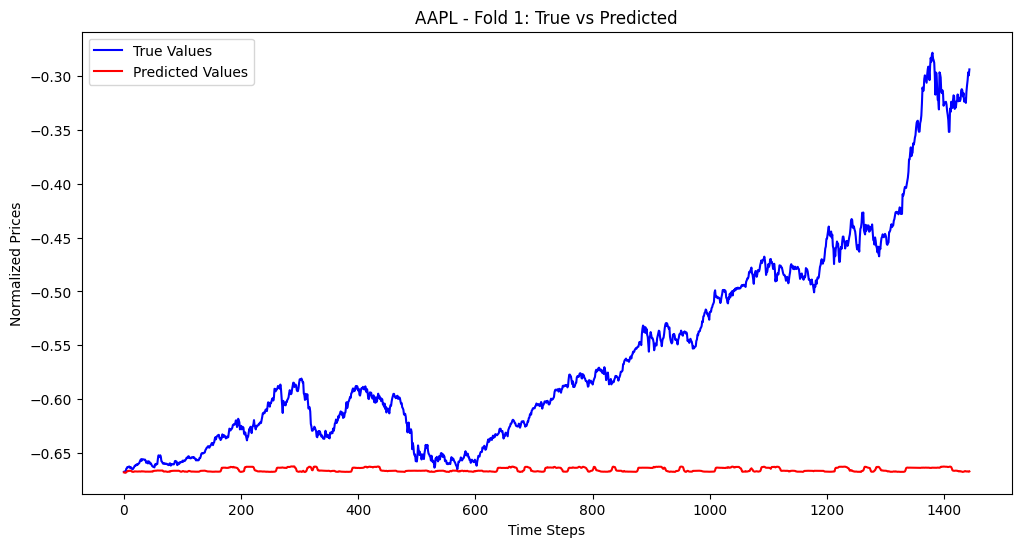

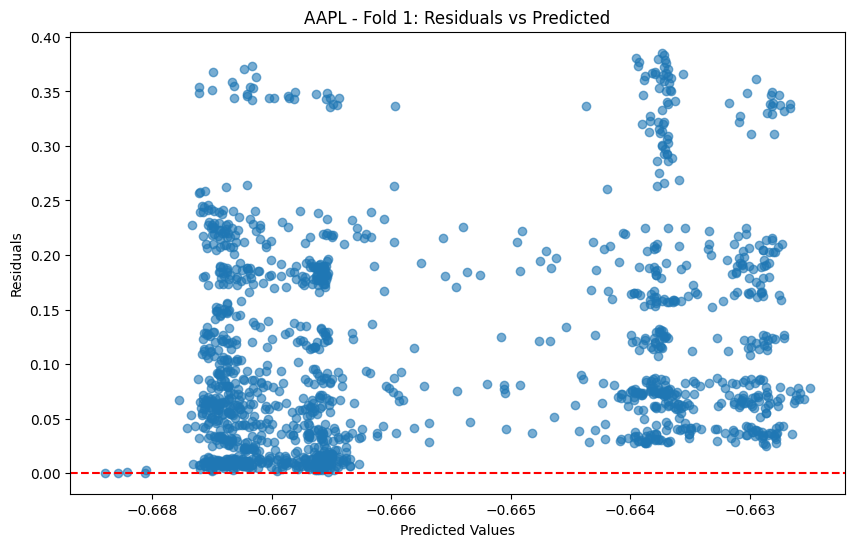

Fold 2...


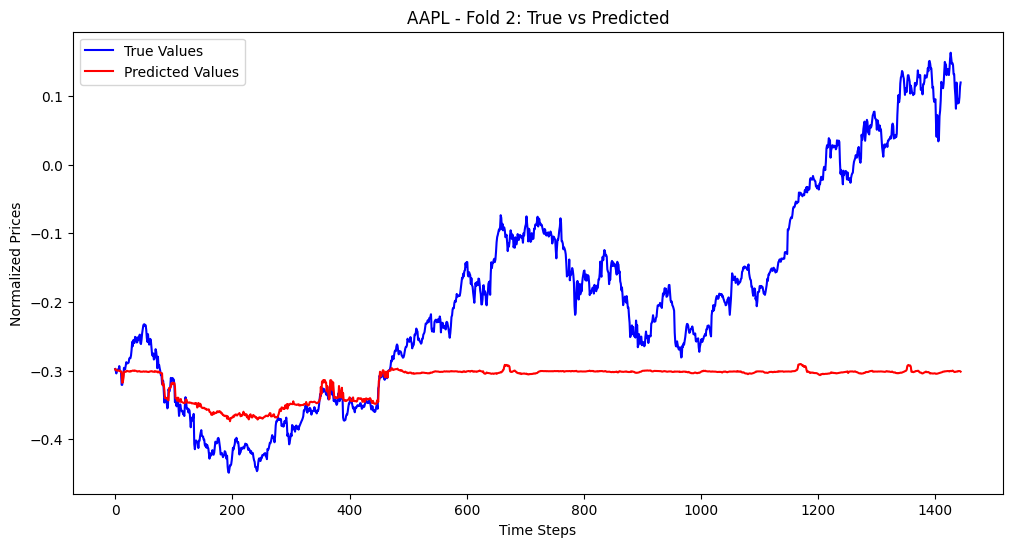

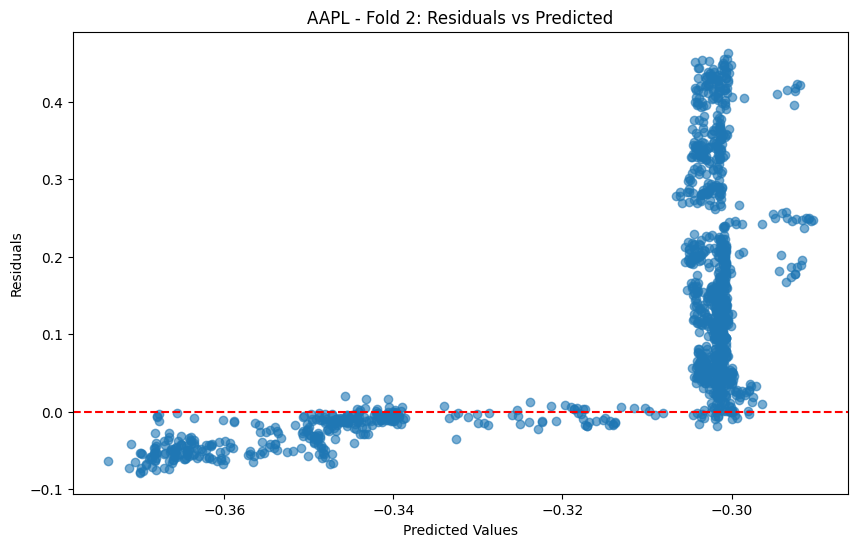

Fold 3...


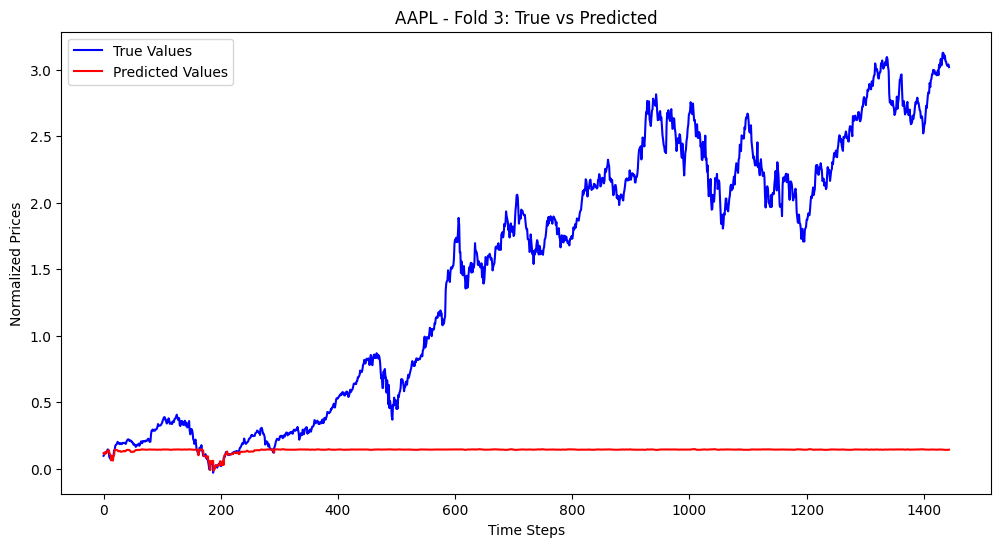

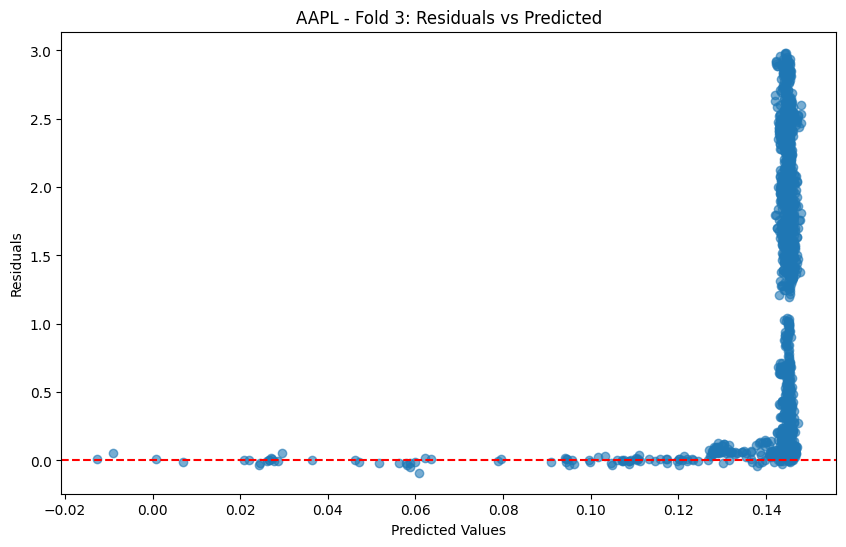


Overall Metrics for AAPL:
Mean Squared Error: 0.9308721841908889
Mean Absolute Error: 0.5290431210643047
R2 Score: 0.16620044320117588
Mean Absolute Percentage Error (MAPE): 1.2146488745762565


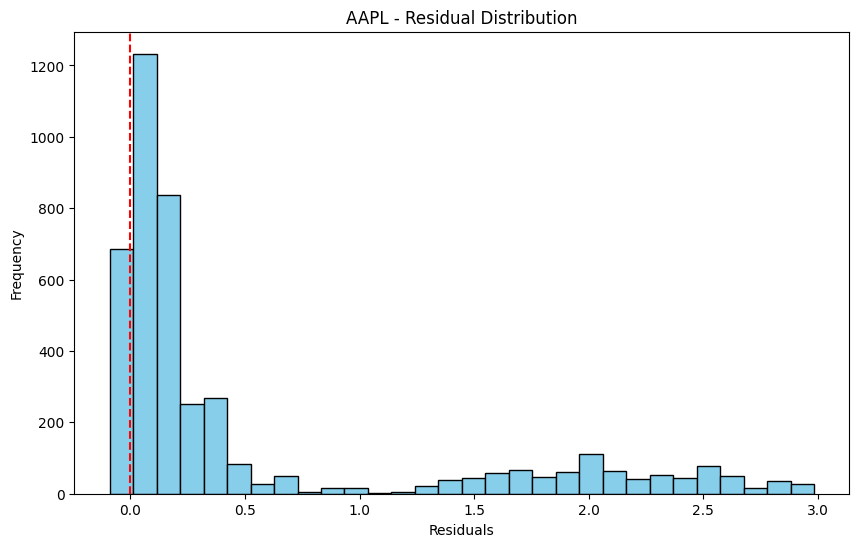


Processing TSLA...


[*********************100%***********************]  1 of 1 completed


Fold 1...


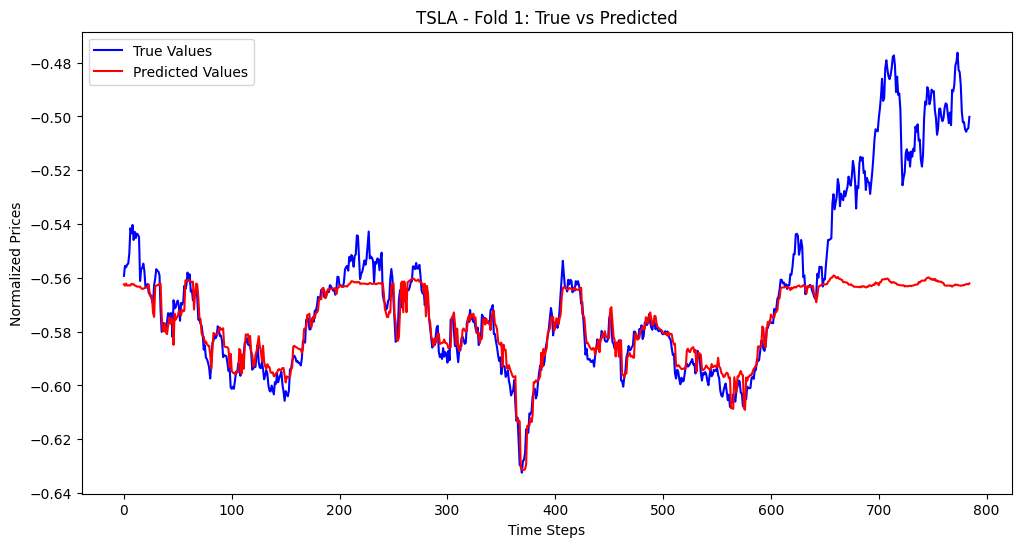

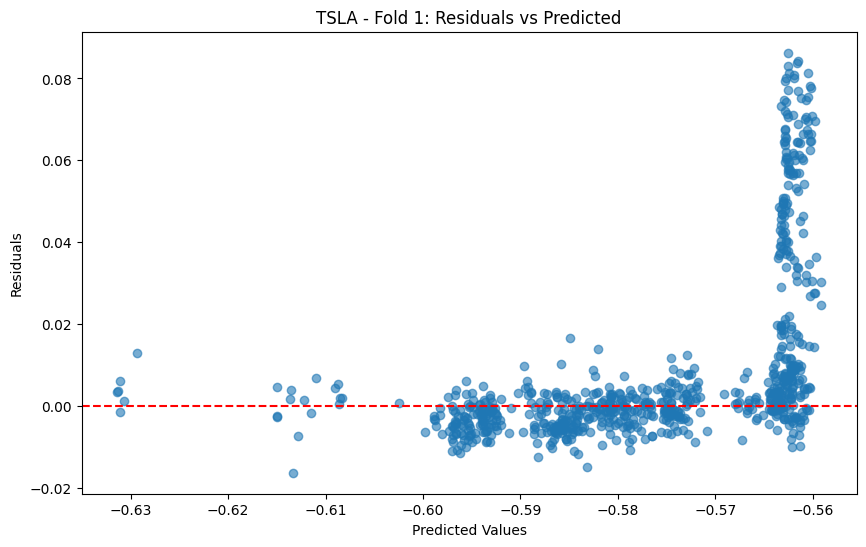

Fold 2...


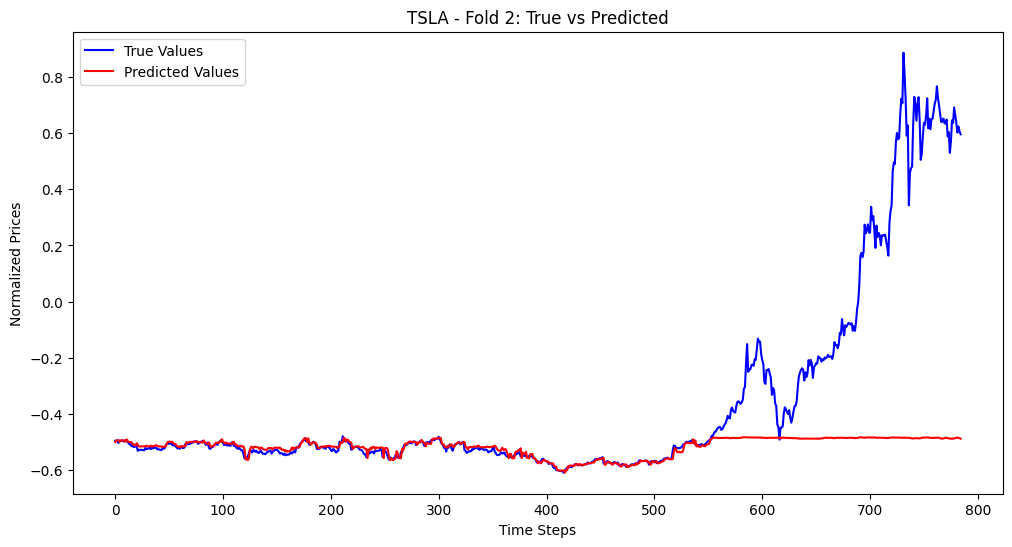

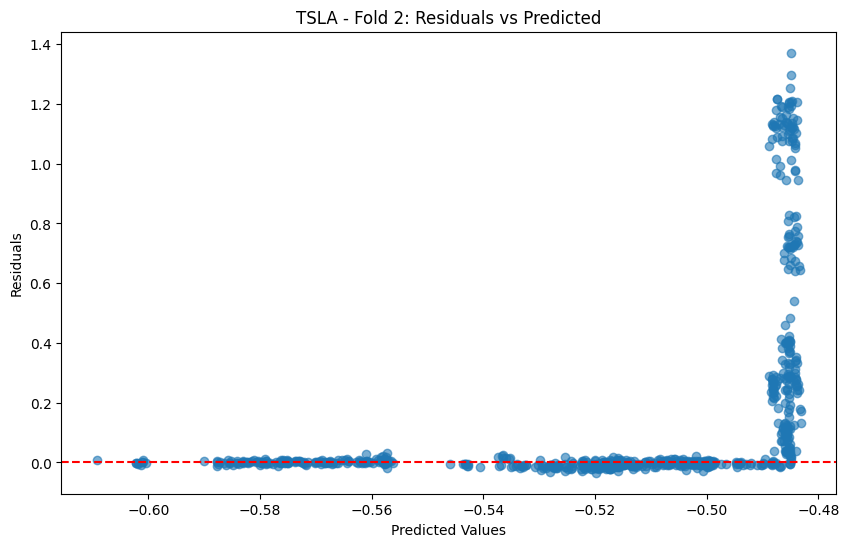

Fold 3...


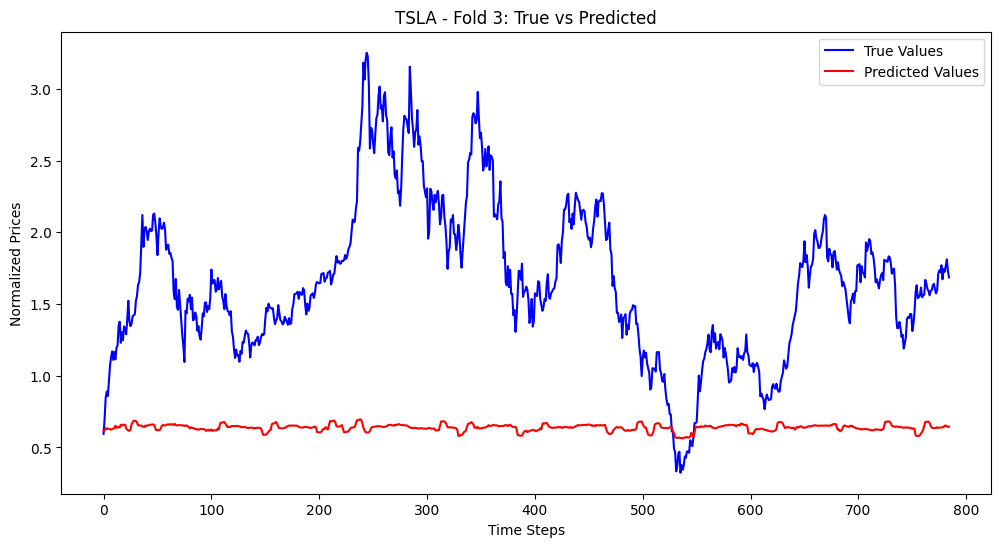

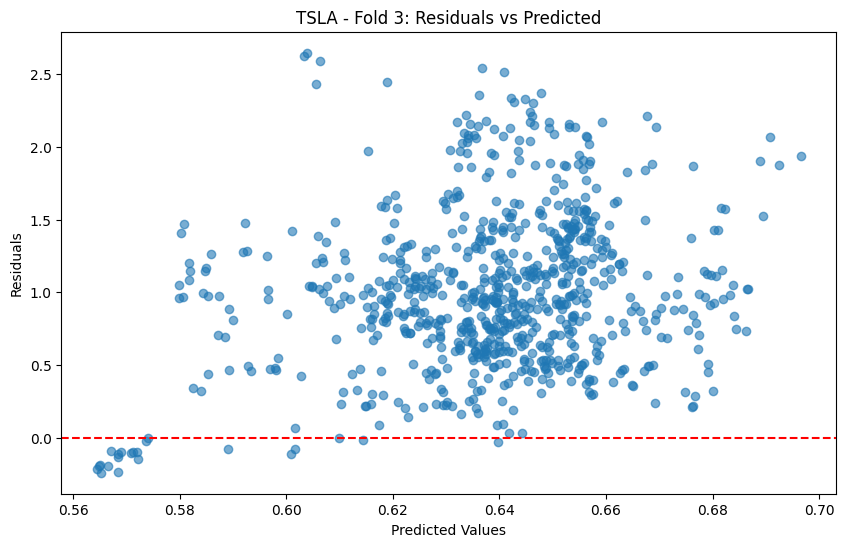


Overall Metrics for TSLA:
Mean Squared Error: 0.4811725463048052
Mean Absolute Error: 0.39794040790484336
R2 Score: 0.5777846693227964
Mean Absolute Percentage Error (MAPE): 0.5585285658843885


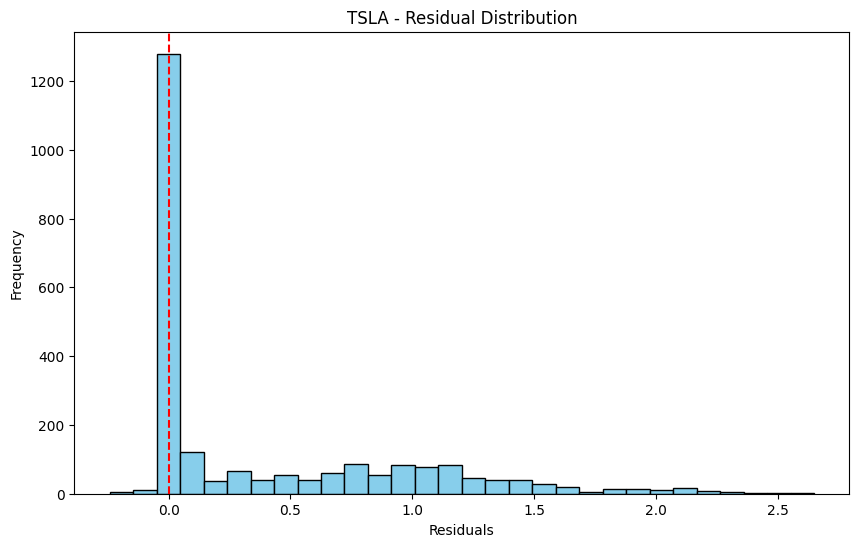


Processing SBIN.NS...


[*********************100%***********************]  1 of 1 completed


Fold 1...


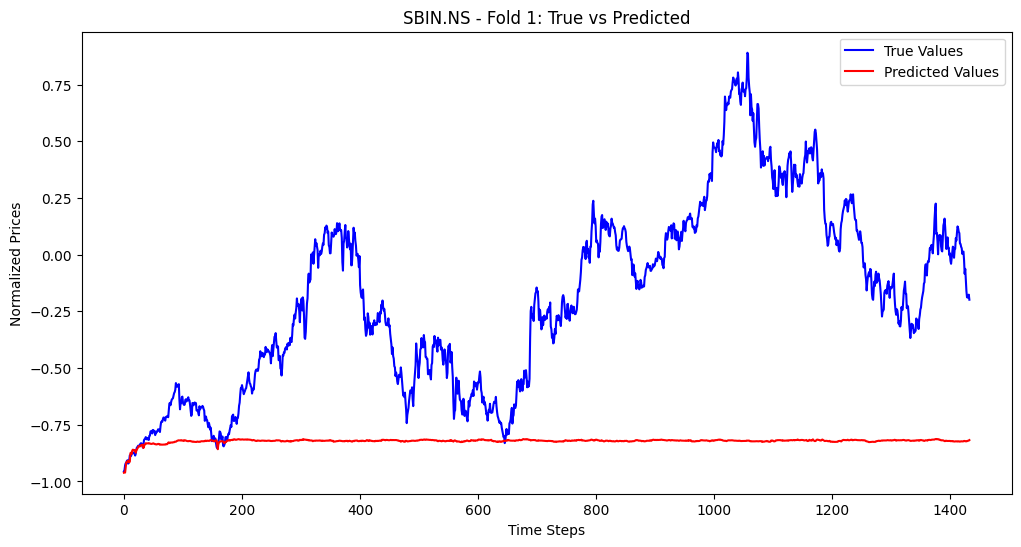

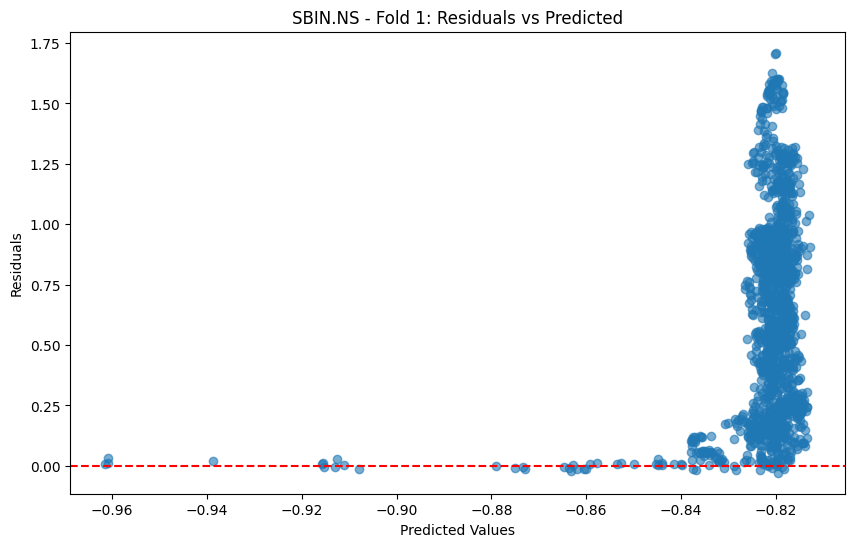

Fold 2...


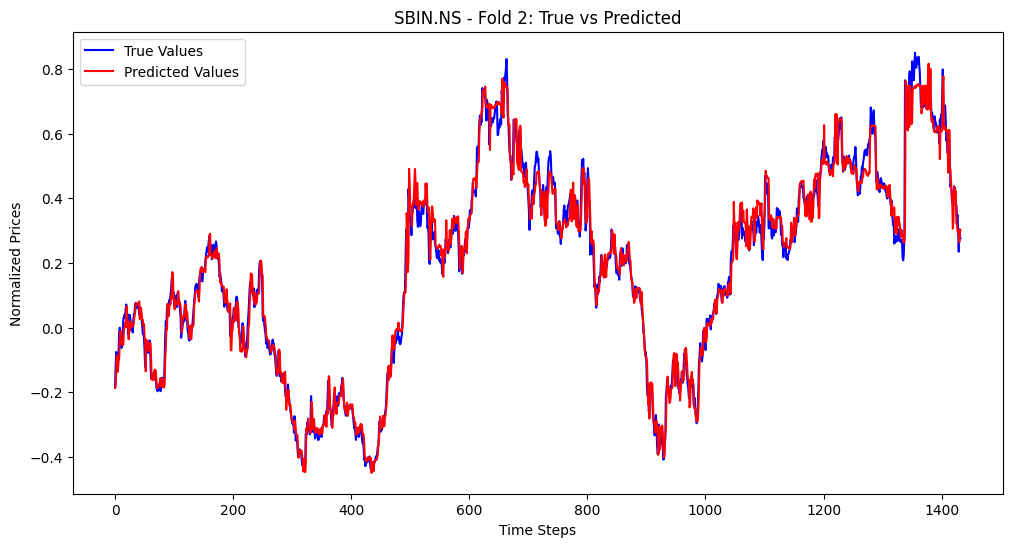

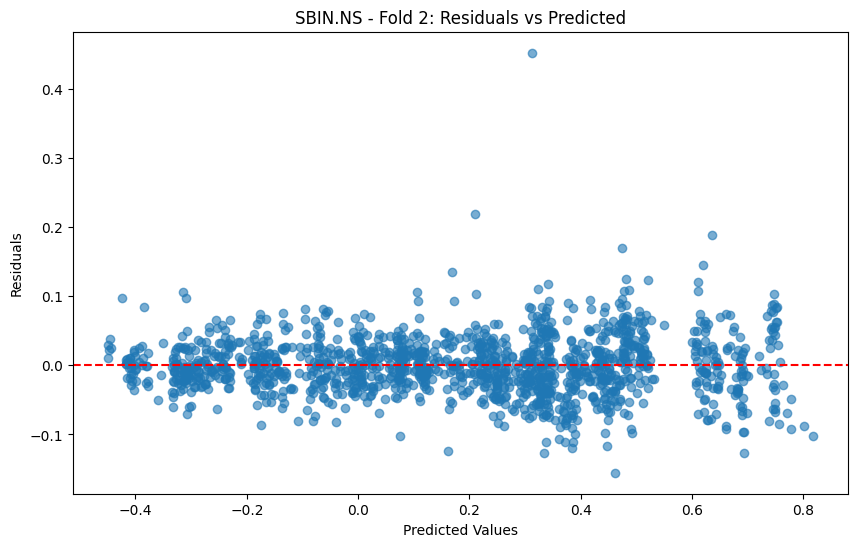

Fold 3...


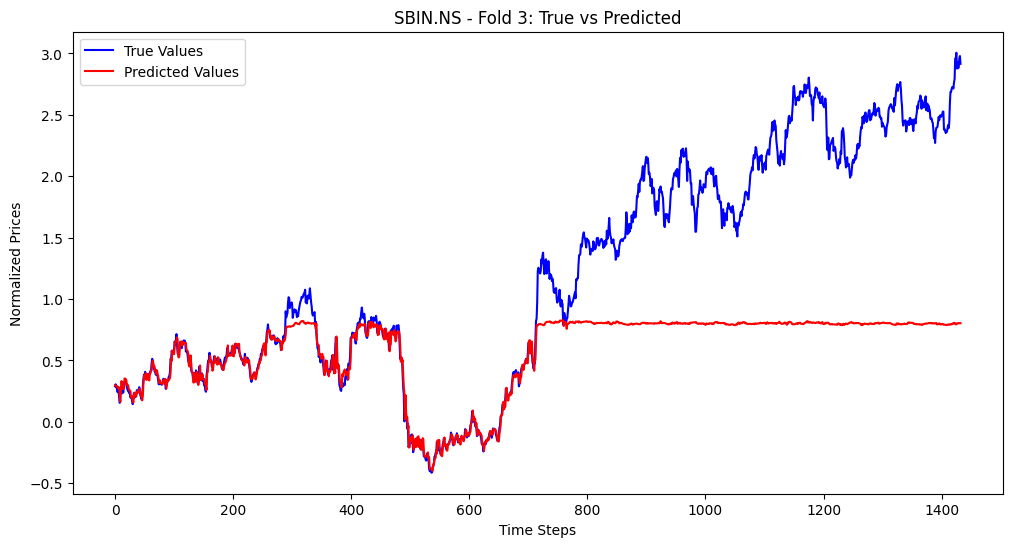

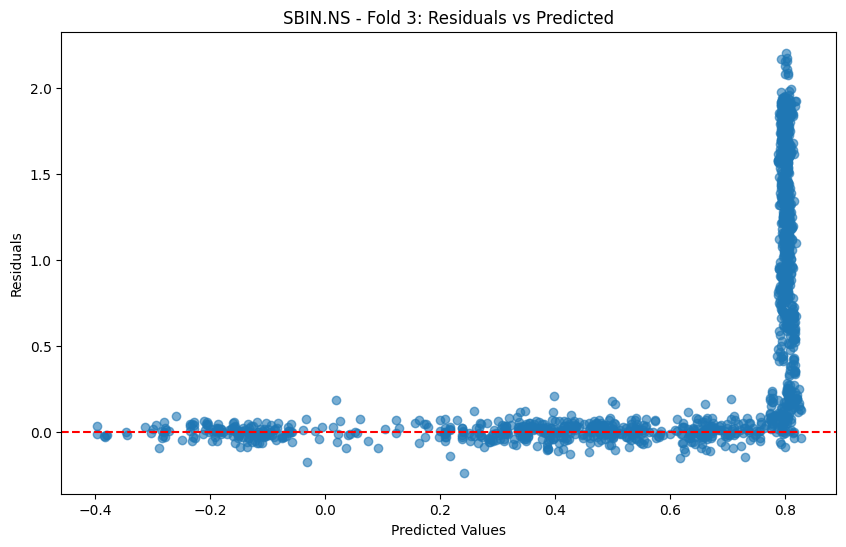


Overall Metrics for SBIN.NS:
Mean Squared Error: 0.4810166651309044
Mean Absolute Error: 0.4330389364601351
R2 Score: 0.33176275231370433
Mean Absolute Percentage Error (MAPE): 4.1735315697999065


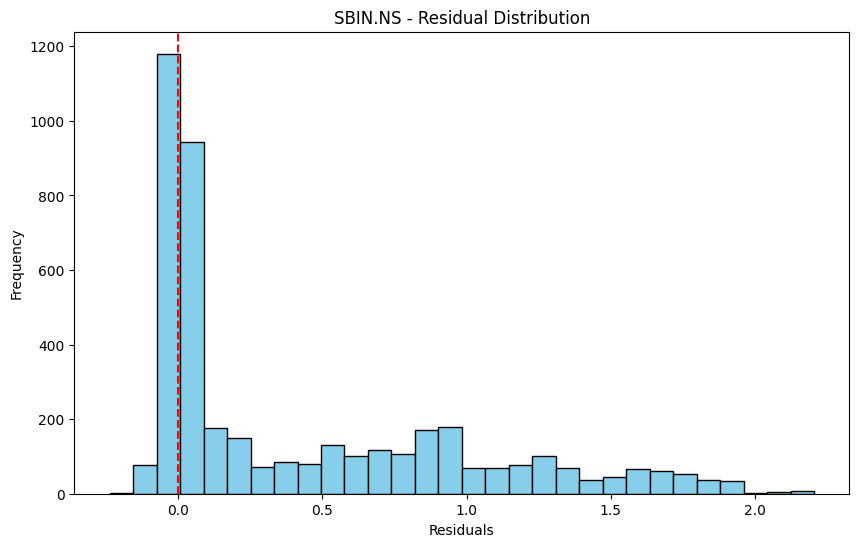


Processing INFY.NS...


[*********************100%***********************]  1 of 1 completed


Fold 1...


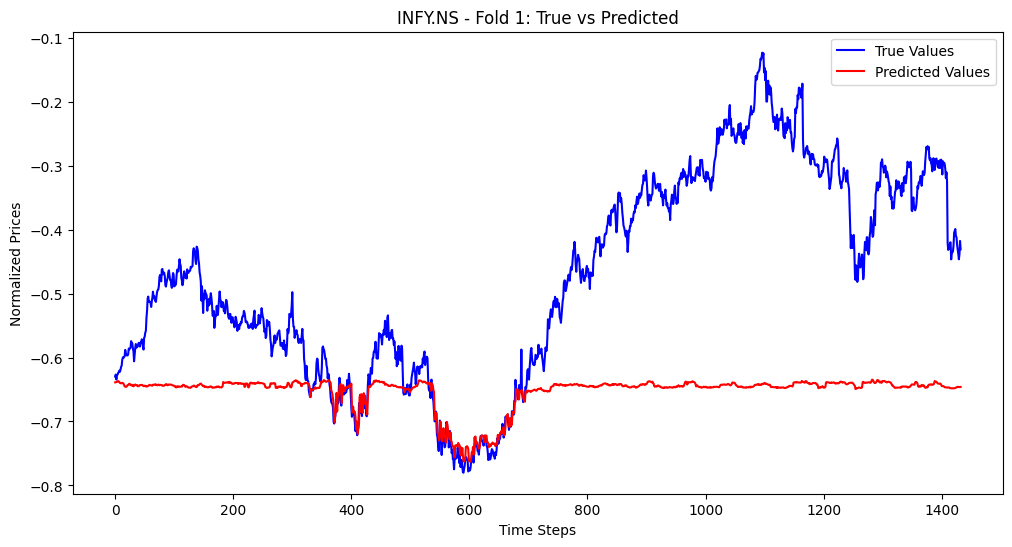

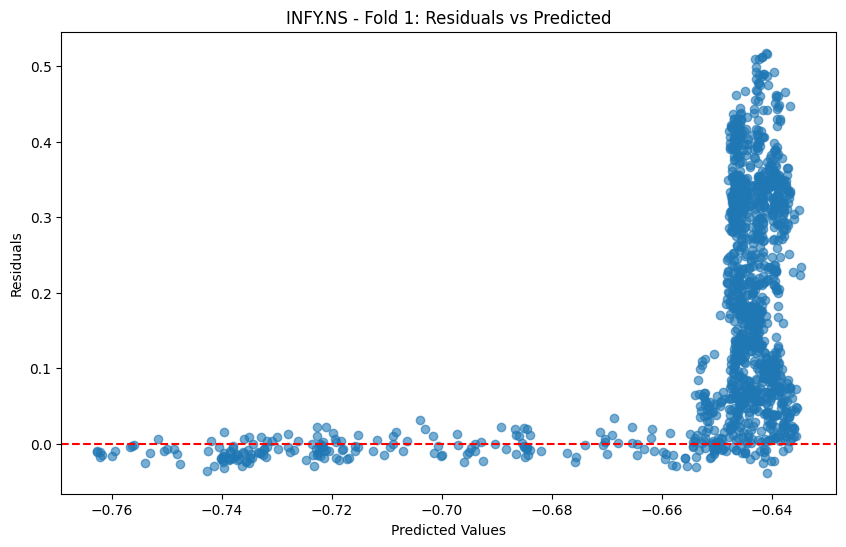

Fold 2...


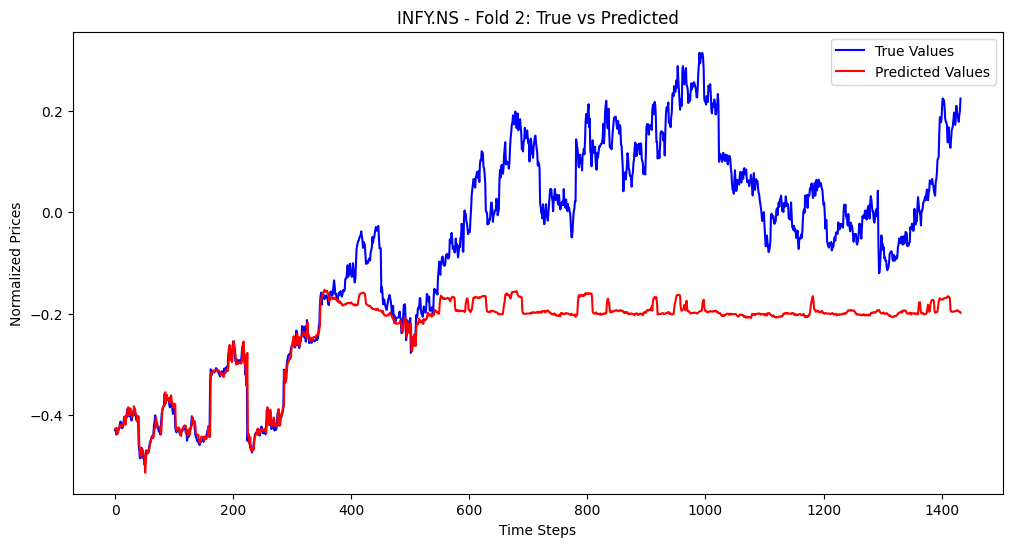

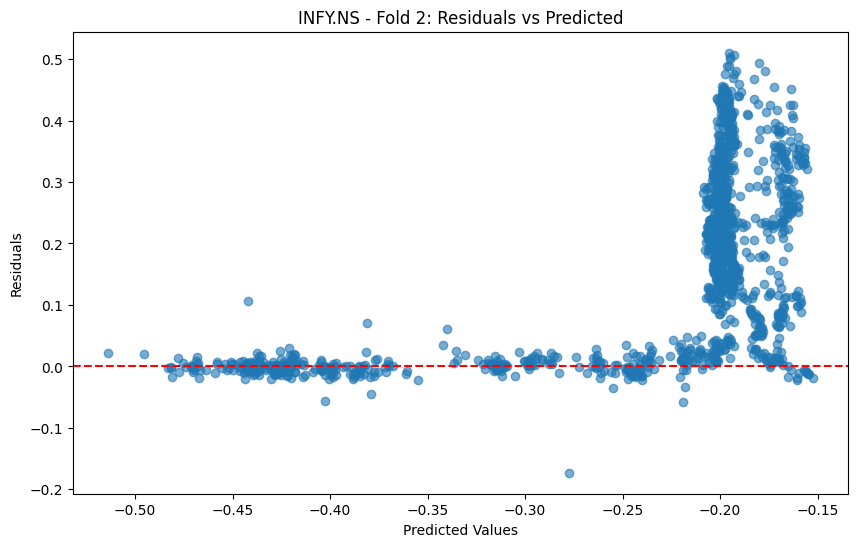

Fold 3...


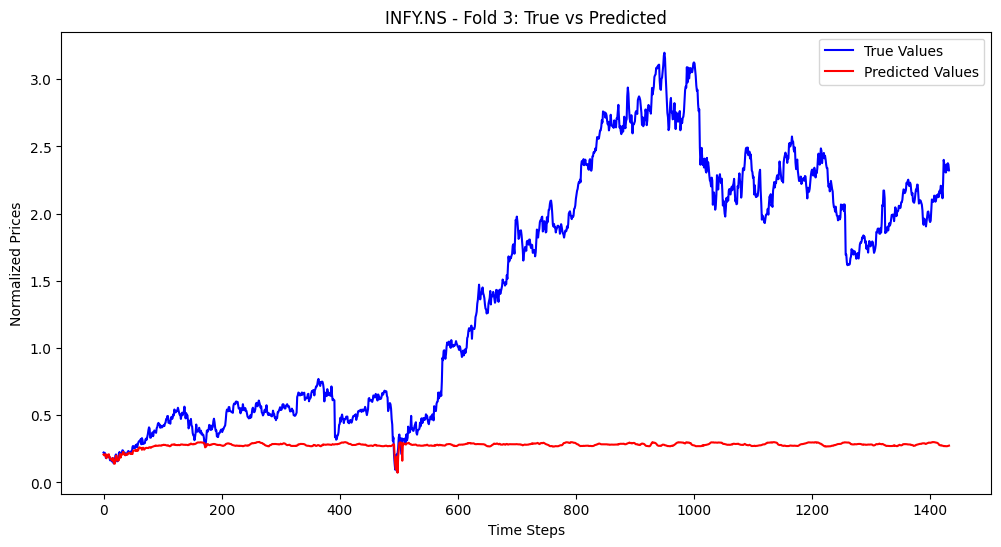

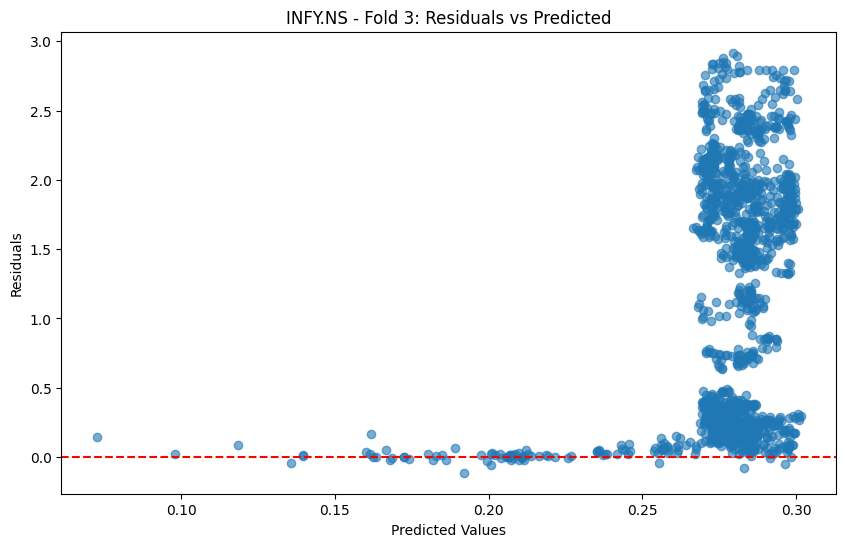


Overall Metrics for INFY.NS:
Mean Squared Error: 0.7646926598516915
Mean Absolute Error: 0.5101301730495296
R2 Score: 0.2247211160040764
Mean Absolute Percentage Error (MAPE): 3.377227426209564


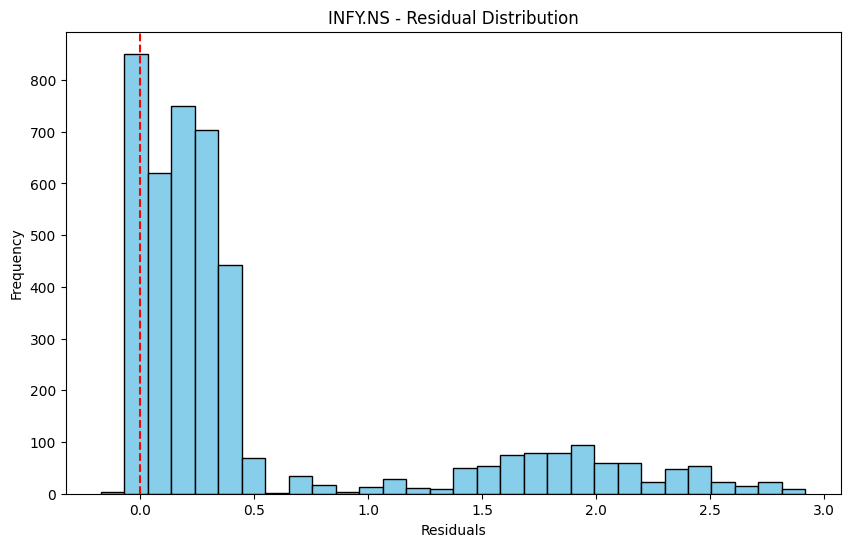


Summary of Performance for All Stocks:
     Stock  Mean MSE  Mean MAE   Mean R2  Mean MAPE
0     AAPL  0.930872  0.529043  0.166200   1.214649
1     TSLA  0.481173  0.397940  0.577785   0.558529
2  SBIN.NS  0.481017  0.433039  0.331763   4.173532
3  INFY.NS  0.764693  0.510130  0.224721   3.377227


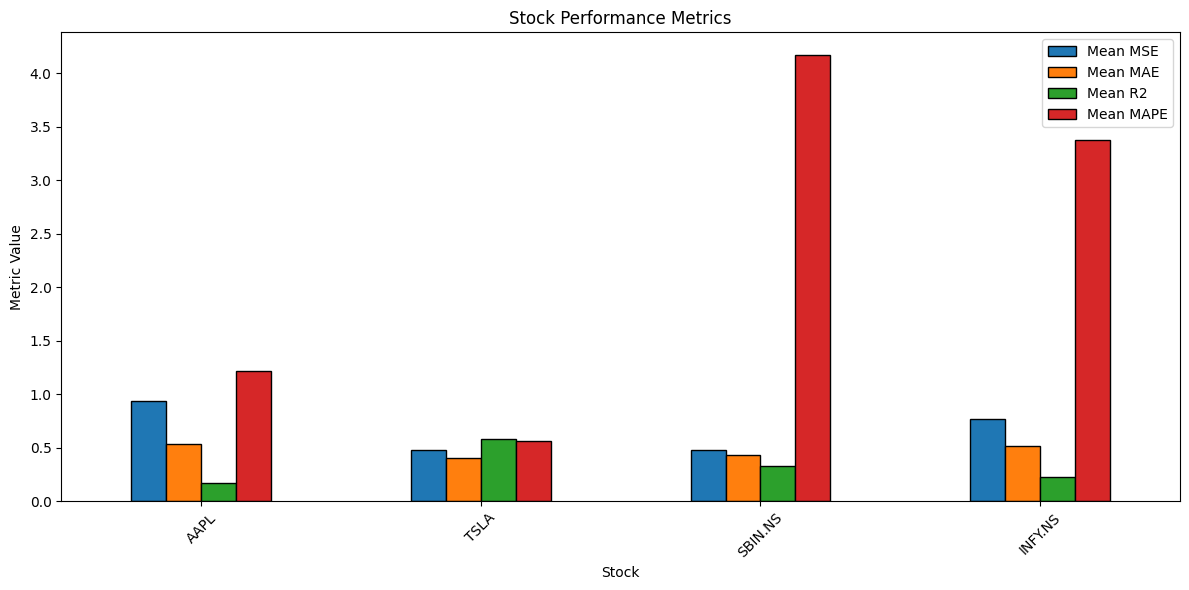

In [ ]:
#Rondom forest regressor
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# List of tickers to process
tickers = ['AAPL', 'TSLA', 'SBIN.NS', 'INFY.NS']  # Add more stocks as needed
start_date = '2000-01-01'
end_date = '2024-01-01'

# Function to create sequences for time series prediction
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])  # Predicting the closing price
    return np.array(X), np.array(y)

# Store overall results
all_results = []
stocks_metrics = []

# Process each stock
for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    # Load stock data
    df = yf.download(ticker, start=start_date, end=end_date)

    # Feature engineering
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()

    # Drop NA values
    df = df.dropna()

    # Selected features for prediction
    features = ['Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']

    # Normalize features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])

    # Create sequences for Random Forest
    sequence_length = 60
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeries Split for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    y_true_all, y_pred_all = [], []

    # Process each fold
    results = []
    for fold, (train_index, test_index) in enumerate(tscv.split(X, y)):
        print(f"Fold {fold + 1}...")

        # Train-test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Random Forest Regressor model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten X_train for Random Forest

        # Predictions
        y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))  # Flatten X_test for Random Forest
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        results.append([ticker, fold + 1, mse, mae, r2, mape])

        # Plot True vs. Predicted for the fold
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='True Values', color='blue')
        plt.plot(y_pred, label='Predicted Values', color='red')
        plt.title(f"{ticker} - Fold {fold + 1}: True vs Predicted")
        plt.xlabel('Time Steps')
        plt.ylabel('Normalized Prices')
        plt.legend()
        plt.show()

        # Plot residuals for the fold
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title(f'{ticker} - Fold {fold + 1}: Residuals vs Predicted')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.show()

    # Overall metrics for the stock
    overall_mse = mean_squared_error(y_true_all, y_pred_all)
    overall_mae = mean_absolute_error(y_true_all, y_pred_all)
    overall_r2 = r2_score(y_true_all, y_pred_all)
    overall_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)

    print(f"\nOverall Metrics for {ticker}:")
    print(f"Mean Squared Error: {overall_mse}")
    print(f"Mean Absolute Error: {overall_mae}")
    print(f"R2 Score: {overall_r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {overall_mape}")

    # Residuals distribution
    residuals = np.array(y_true_all) - np.array(y_pred_all)
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', color='skyblue')
    plt.title(f'{ticker} - Residual Distribution')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Combine fold results into DataFrame
    results_df = pd.DataFrame(results, columns=['Ticker', 'Fold', 'MSE', 'MAE', 'R2 Score', 'MAPE'])
    all_results.append(results_df)

    # Store overall metrics
    stocks_metrics.append([ticker, overall_mse, overall_mae, overall_r2, overall_mape])

# Combine results for all stocks
all_results_df = pd.concat(all_results, ignore_index=True)
stocks_metrics_df = pd.DataFrame(stocks_metrics, columns=['Stock', 'Mean MSE', 'Mean MAE', 'Mean R2', 'Mean MAPE'])

# Print combined results
print("\nSummary of Performance for All Stocks:")
print(stocks_metrics_df)

# Plot performance metrics
stocks_metrics_df.plot(x='Stock', kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Stock Performance Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Processing AAPL...


Fold 1...


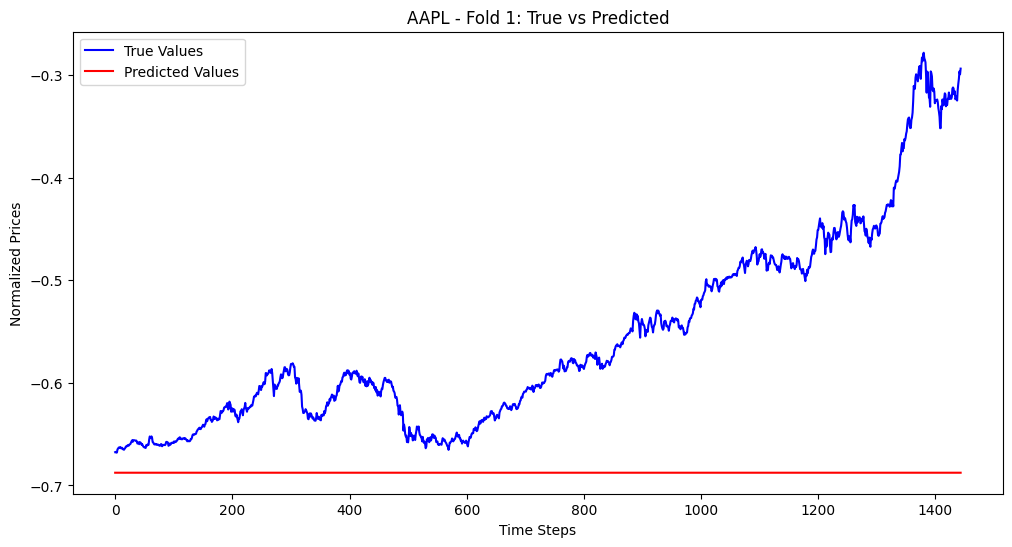

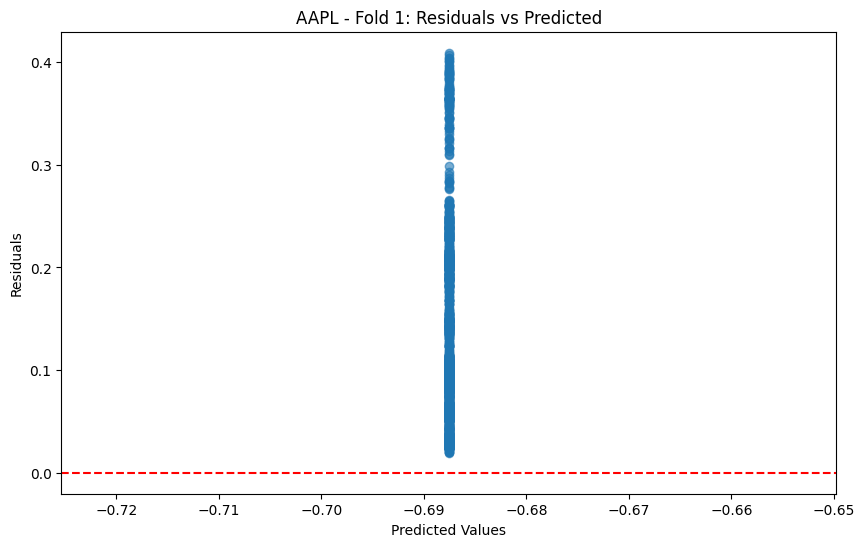

Fold 2...


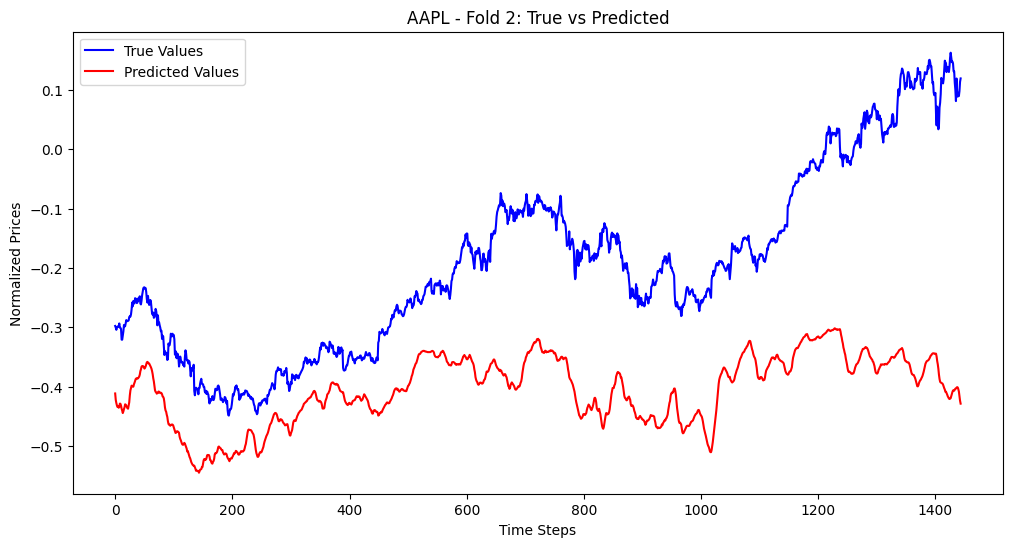

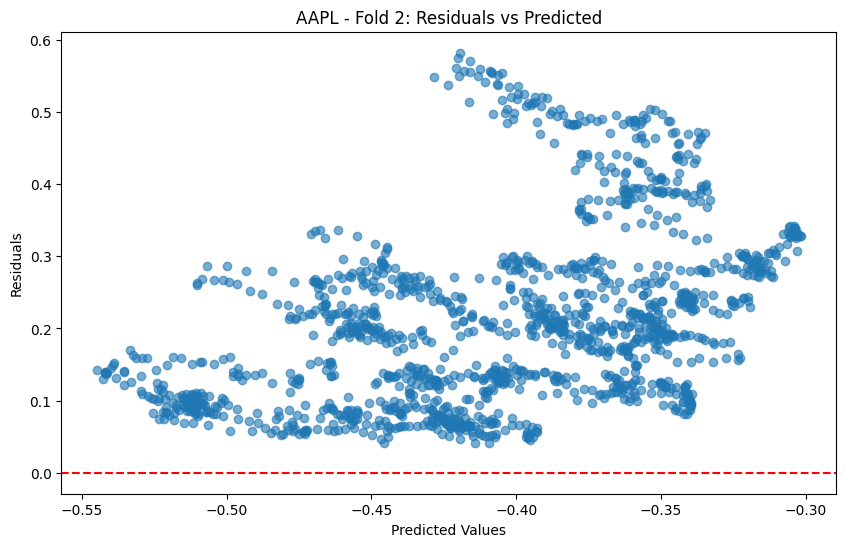

Fold 3...


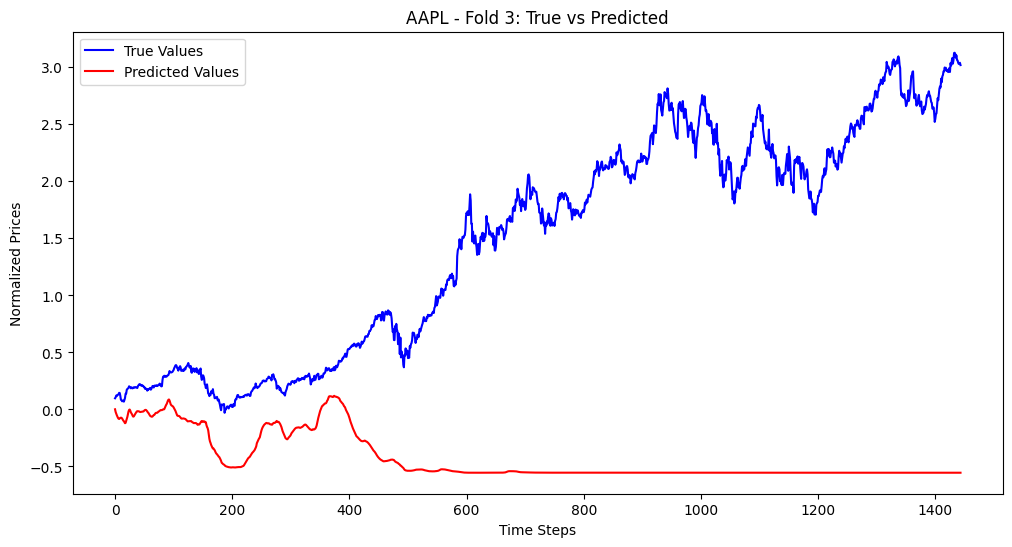

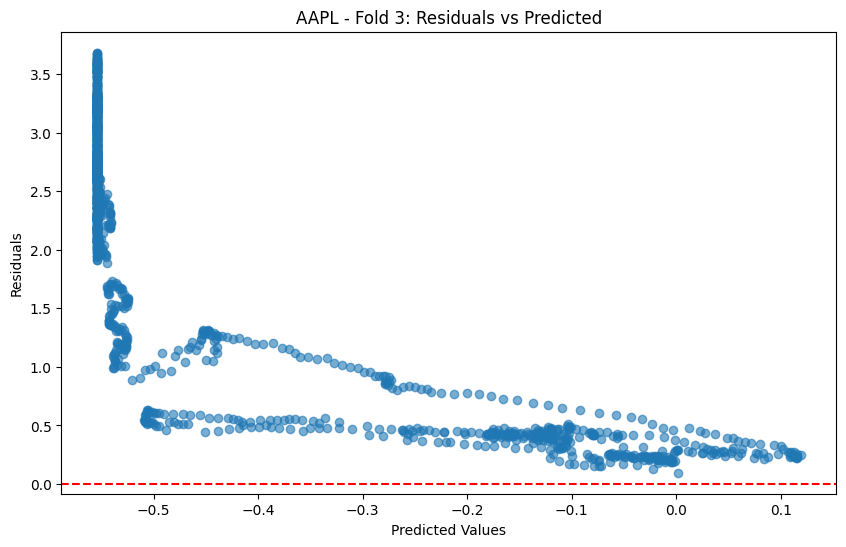


Overall Metrics for AAPL:
Mean Squared Error: 1.6744416108998337
Mean Absolute Error: 0.7508854867363903
R2 Score: -0.49982854441753277
Mean Absolute Percentage Error (MAPE): 2.266106820868781


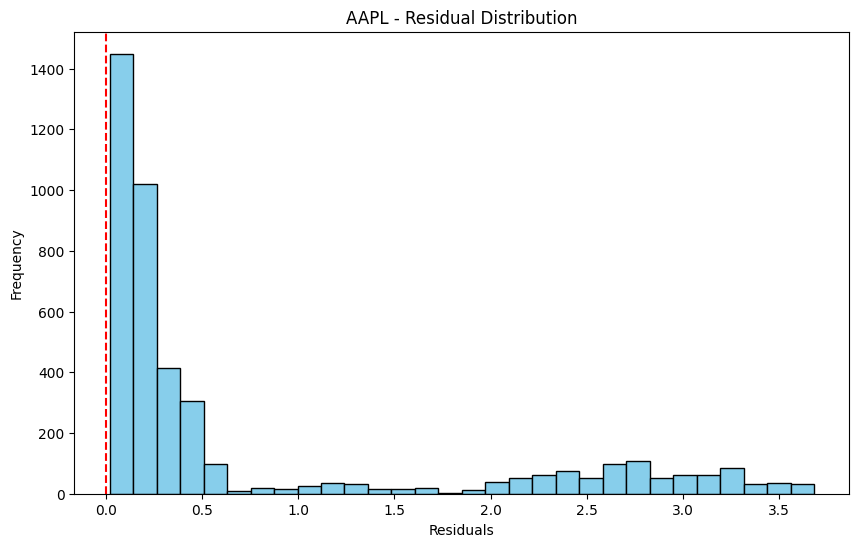

[*********************100%***********************]  1 of 1 completed


Processing TSLA...
Fold 1...


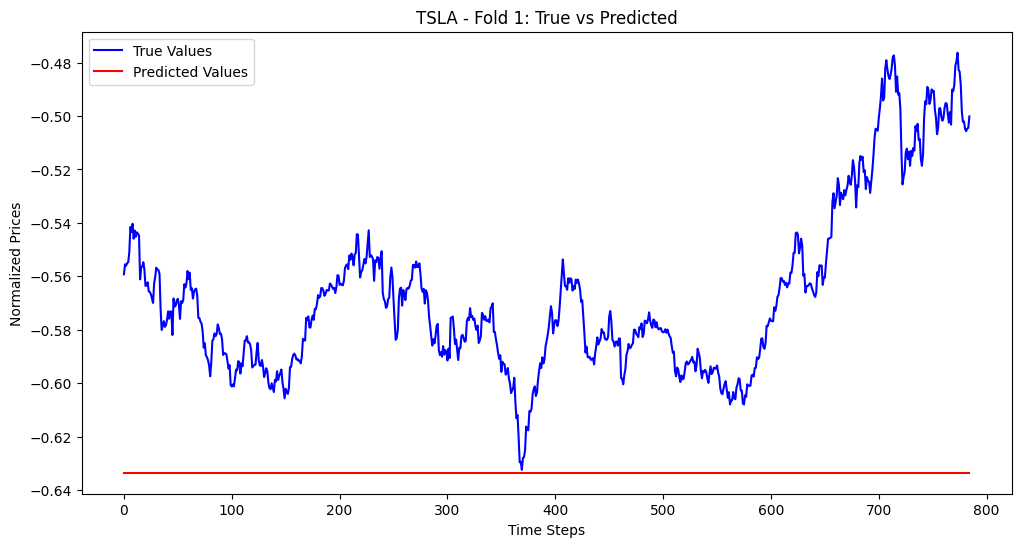

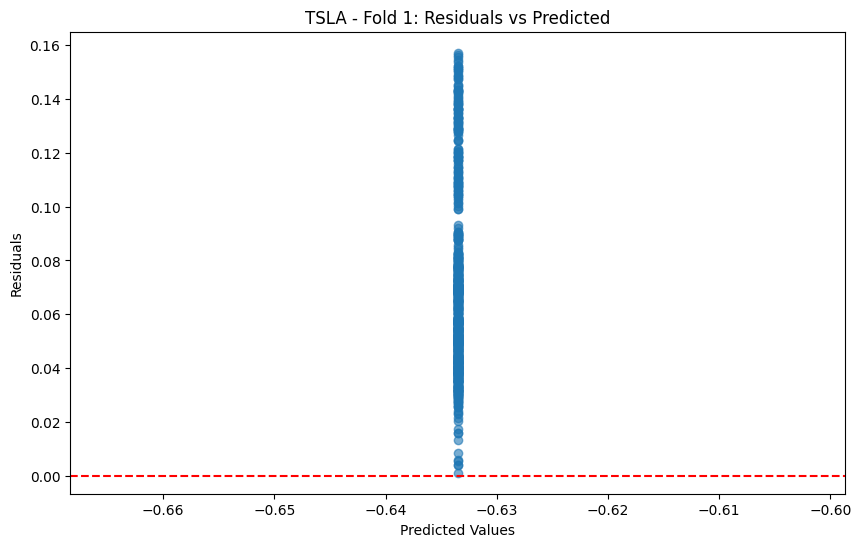

Fold 2...


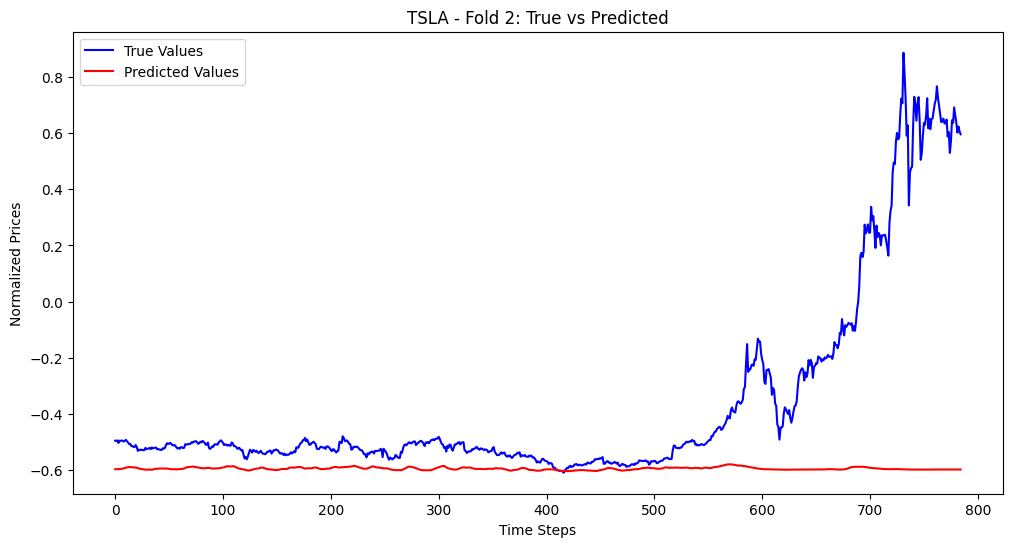

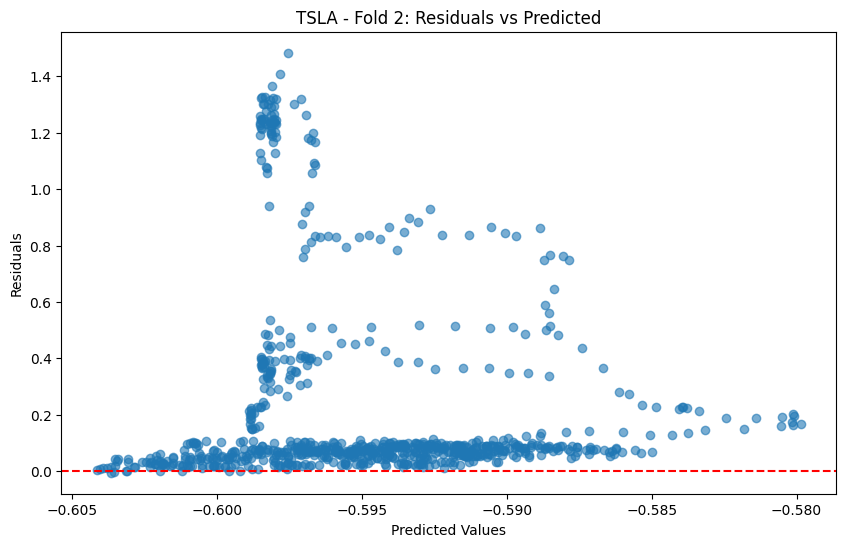

Fold 3...


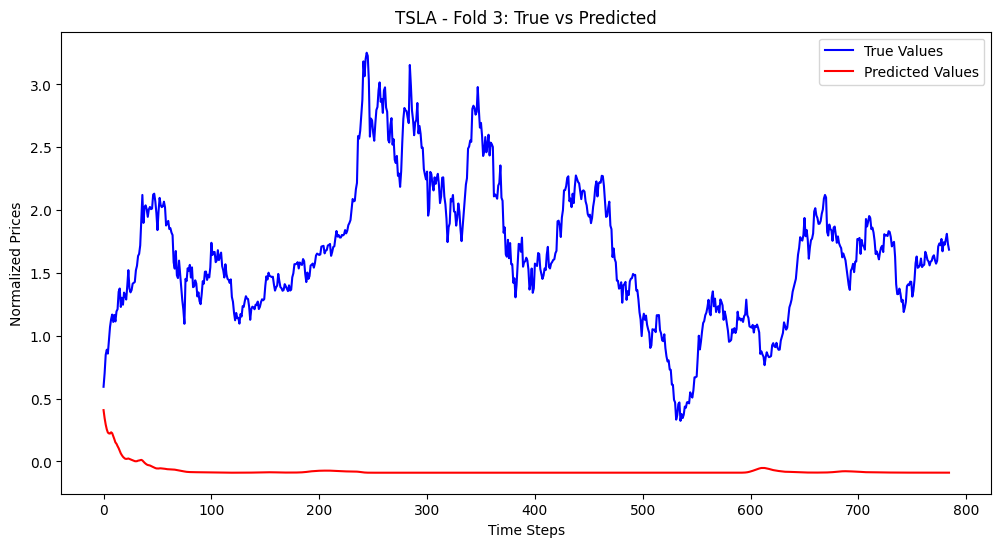

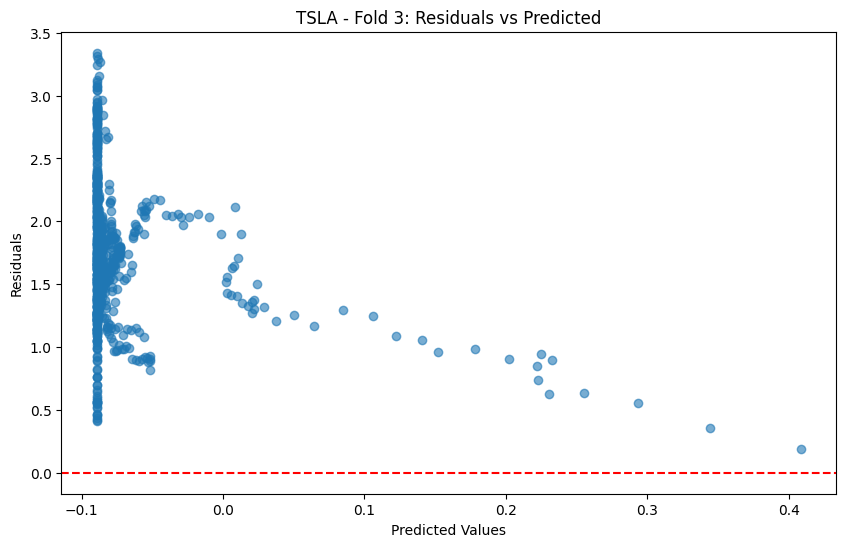


Overall Metrics for TSLA:
Mean Squared Error: 1.1550389994246333
Mean Absolute Error: 0.6752015847387294
R2 Score: -0.013514126756129619
Mean Absolute Percentage Error (MAPE): 0.8545509669272828


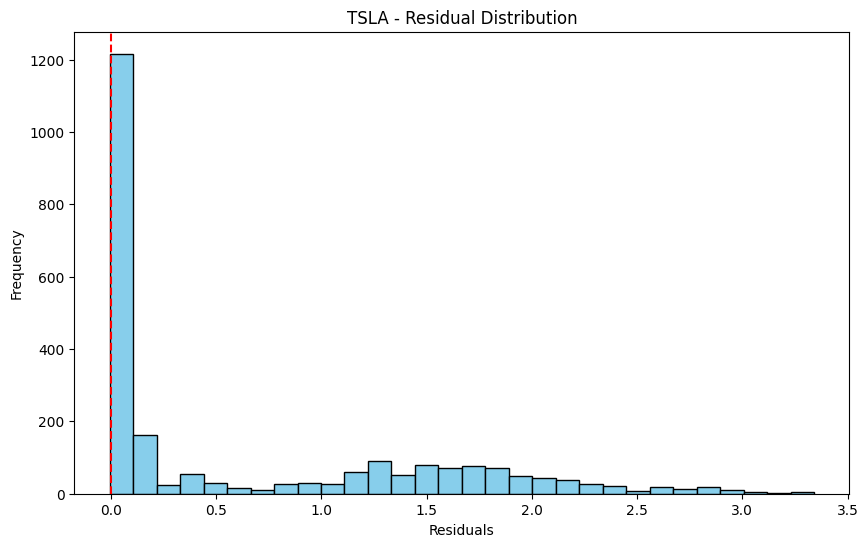

[*********************100%***********************]  1 of 1 completed


Processing SBIN.NS...
Fold 1...


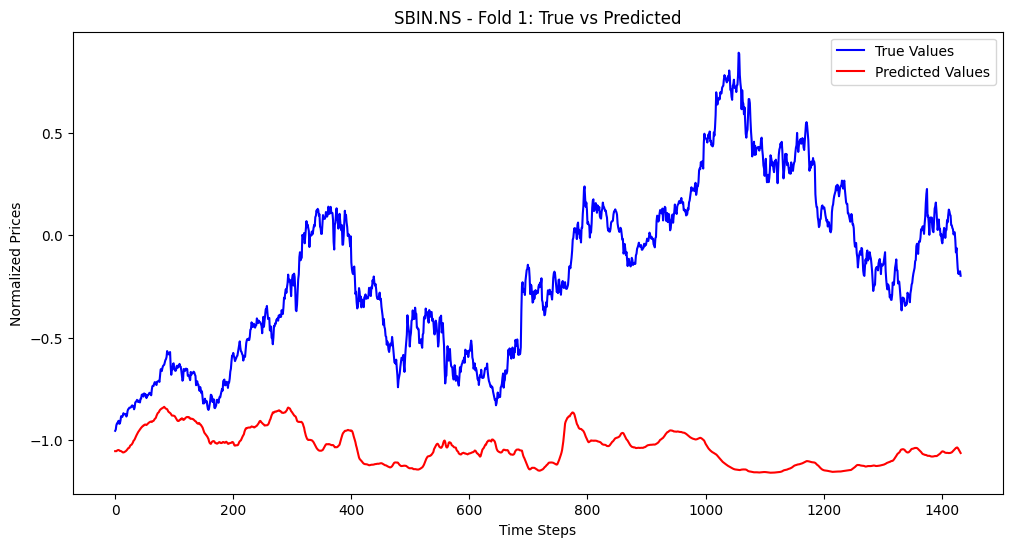

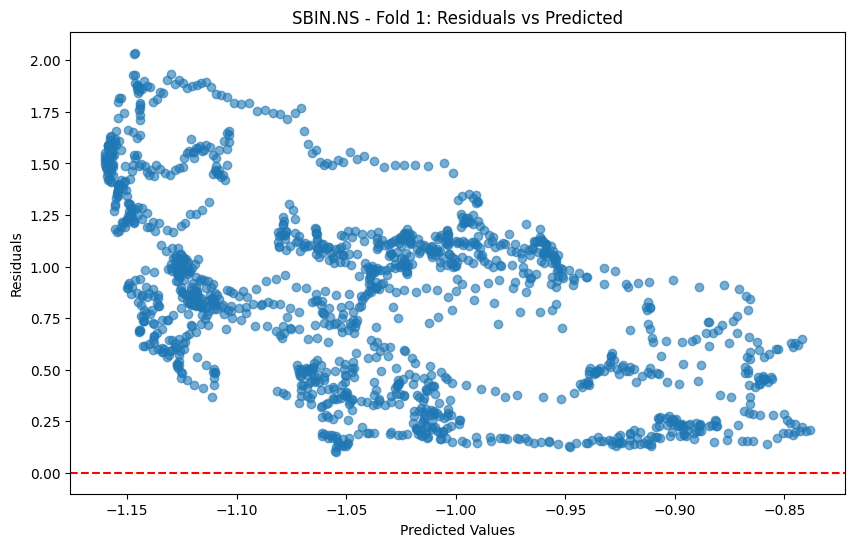

Fold 2...


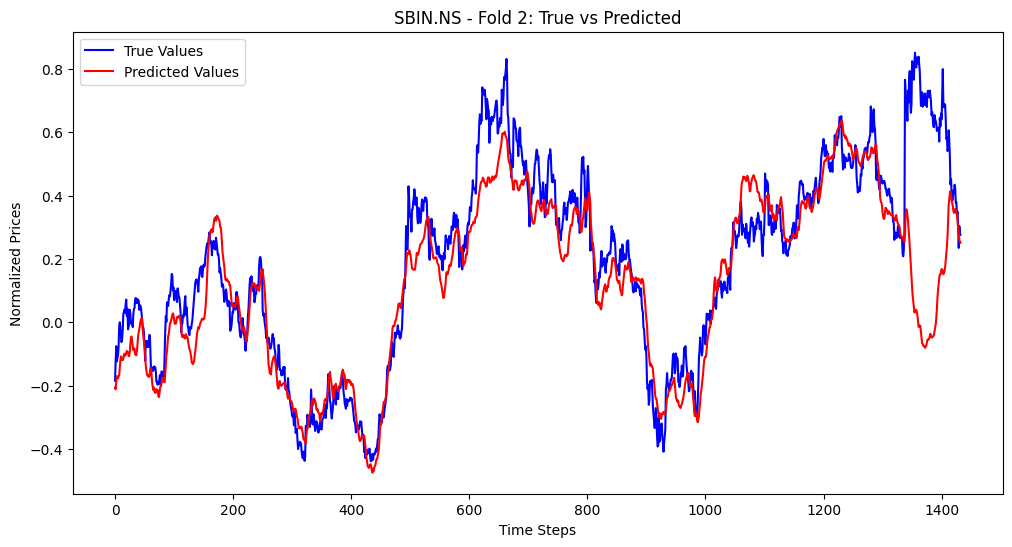

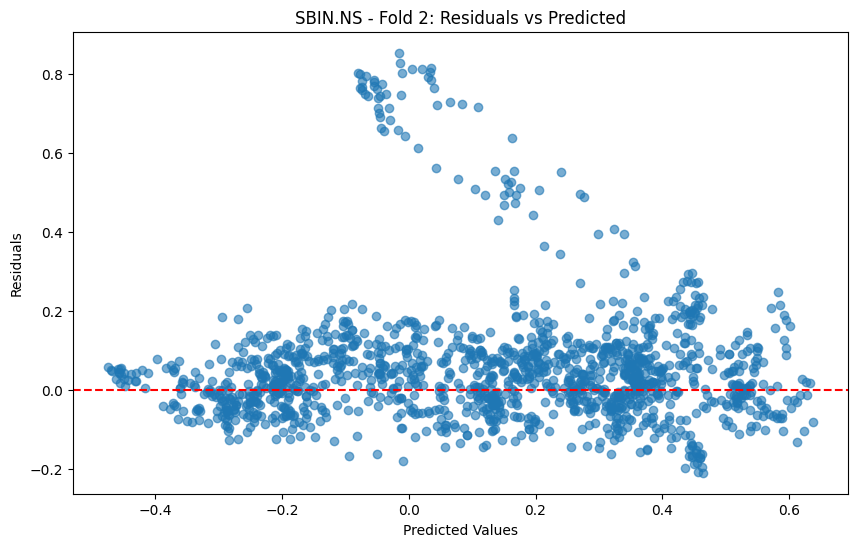

Fold 3...


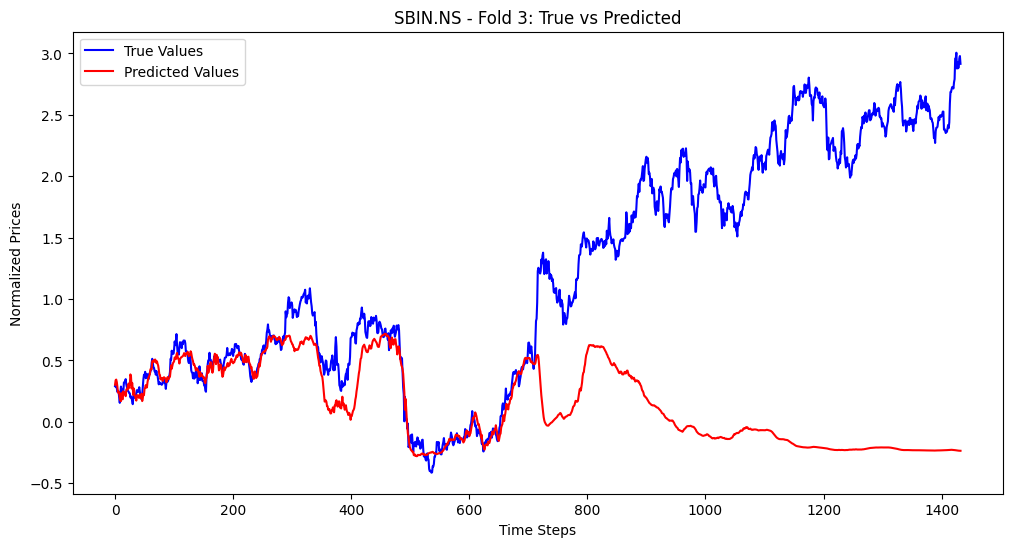

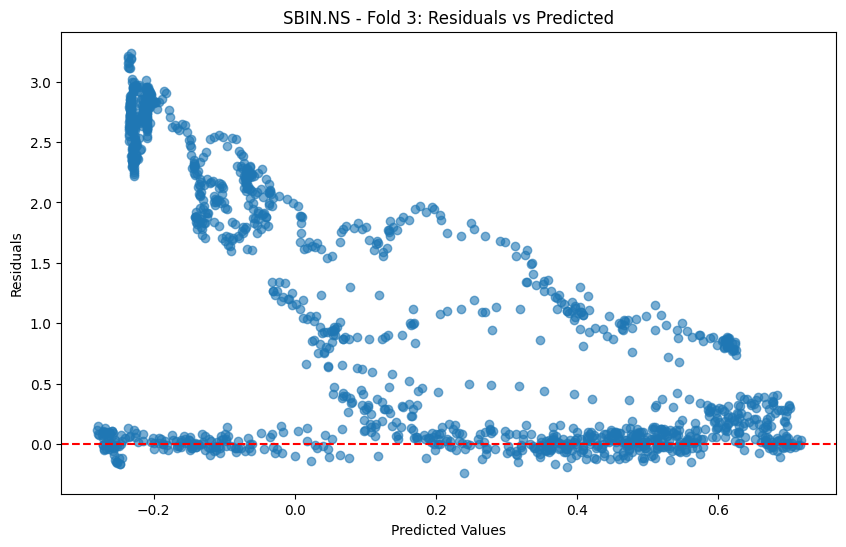


Overall Metrics for SBIN.NS:
Mean Squared Error: 1.1045442753789865
Mean Absolute Error: 0.6775504373444744
R2 Score: -0.5344533360939605
Mean Absolute Percentage Error (MAPE): 5.423707535798049


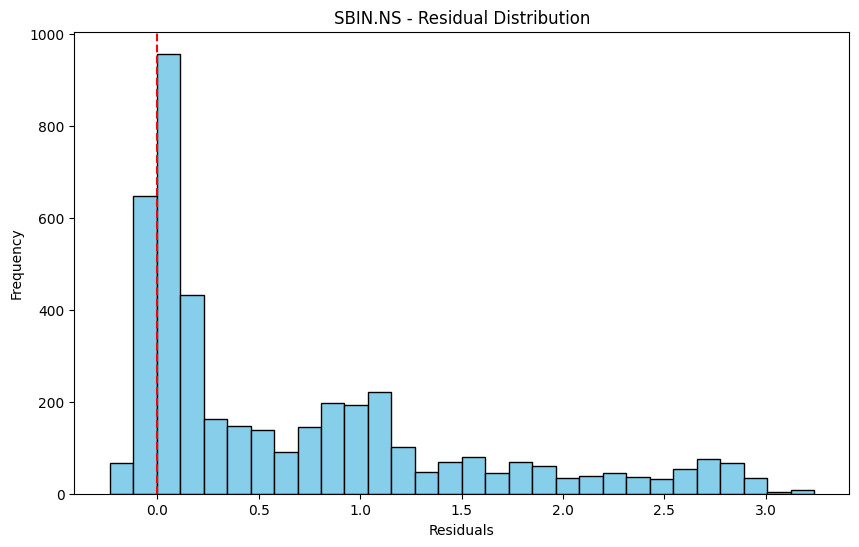

[*********************100%***********************]  1 of 1 completed


Processing INFY.NS...
Fold 1...


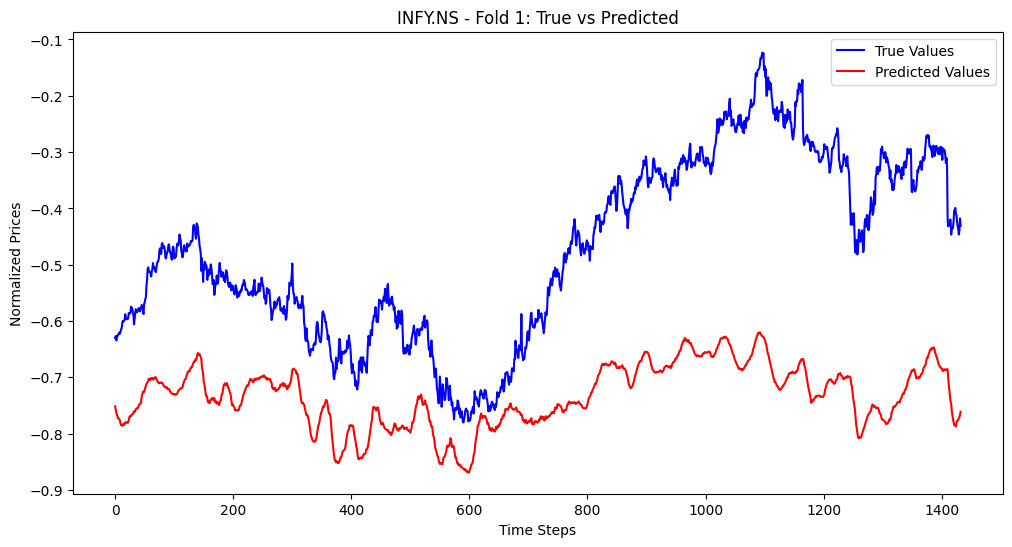

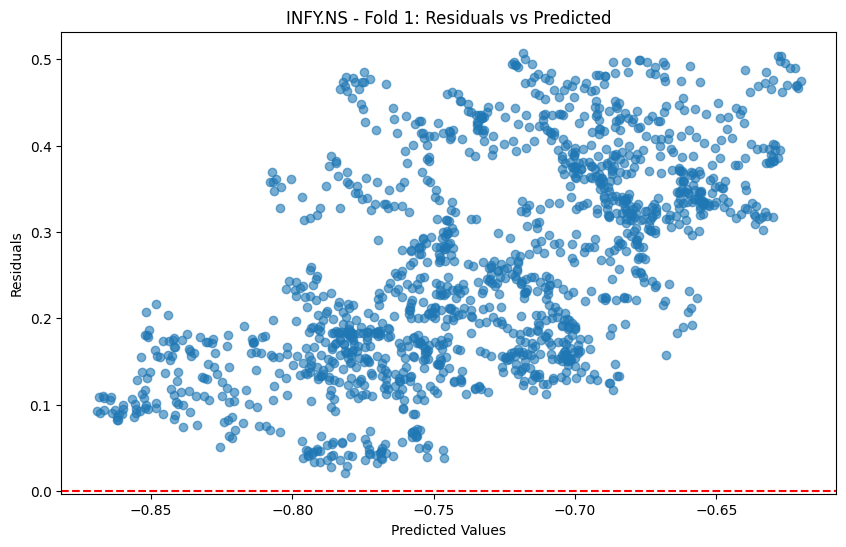

Fold 2...


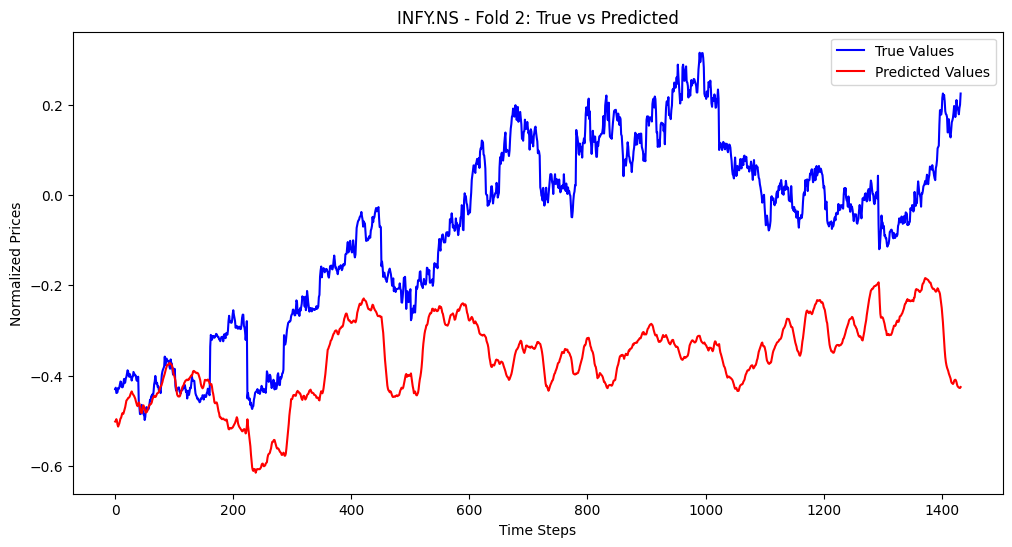

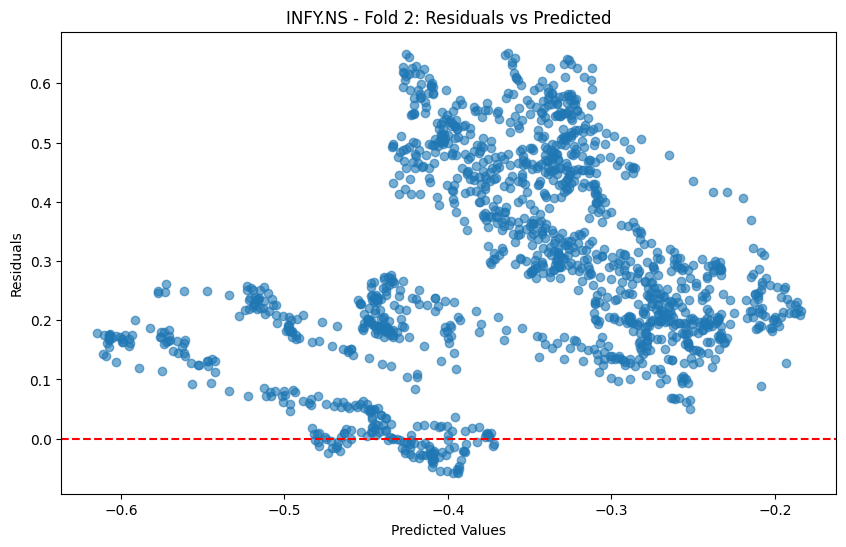

Fold 3...


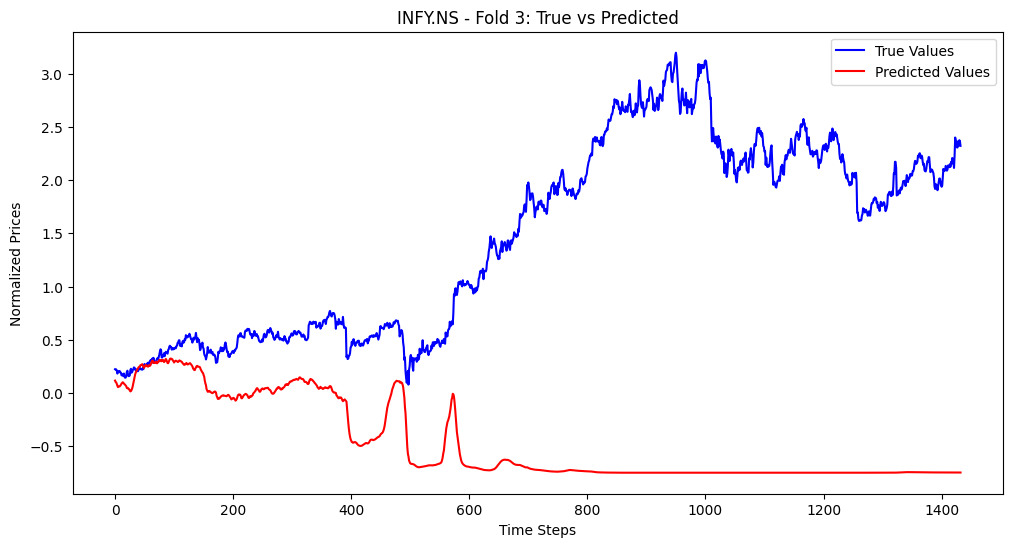

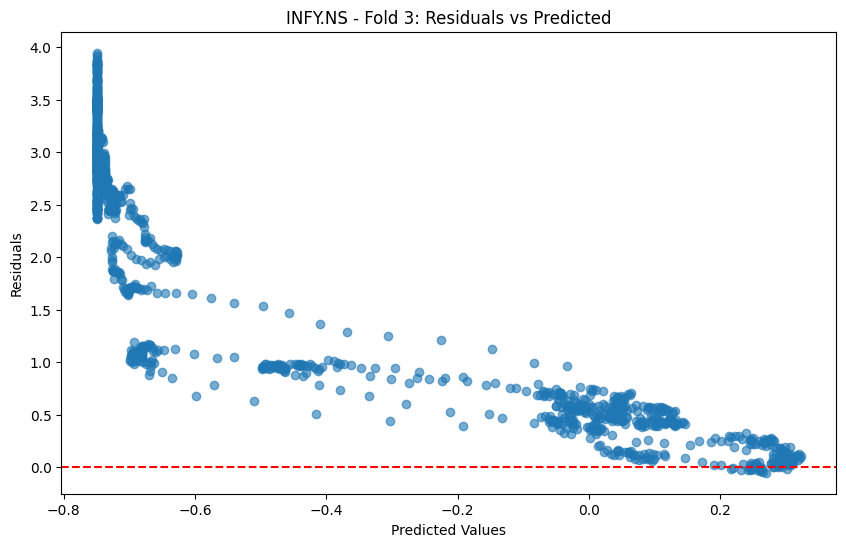


Overall Metrics for INFY.NS:
Mean Squared Error: 1.798405979138314
Mean Absolute Error: 0.8239471282497752
R2 Score: -0.8233026857461396
Mean Absolute Percentage Error (MAPE): 5.388863113416838


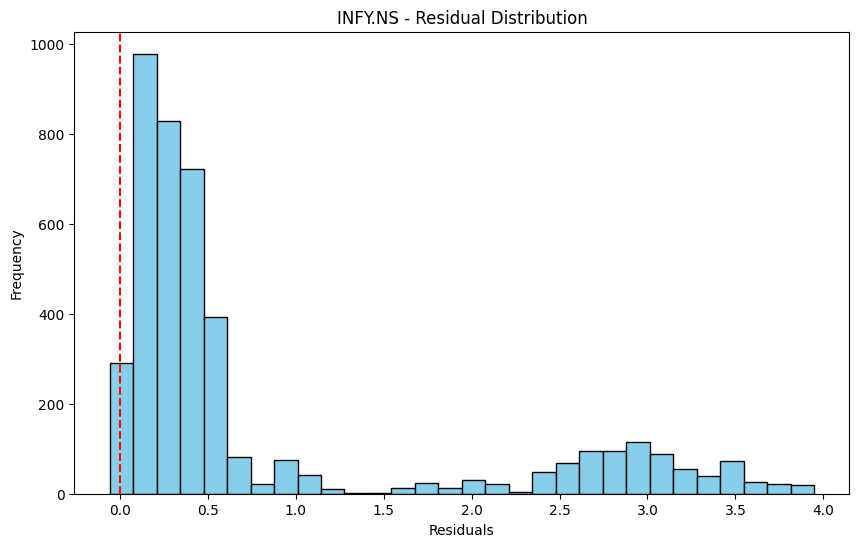


Summary of Performance for All Stocks:
     Stock  Mean MSE  Mean MAE   Mean R2  Mean MAPE
0     AAPL  1.674442  0.750885 -0.499829   2.266107
1     TSLA  1.155039  0.675202 -0.013514   0.854551
2  SBIN.NS  1.104544  0.677550 -0.534453   5.423708
3  INFY.NS  1.798406  0.823947 -0.823303   5.388863


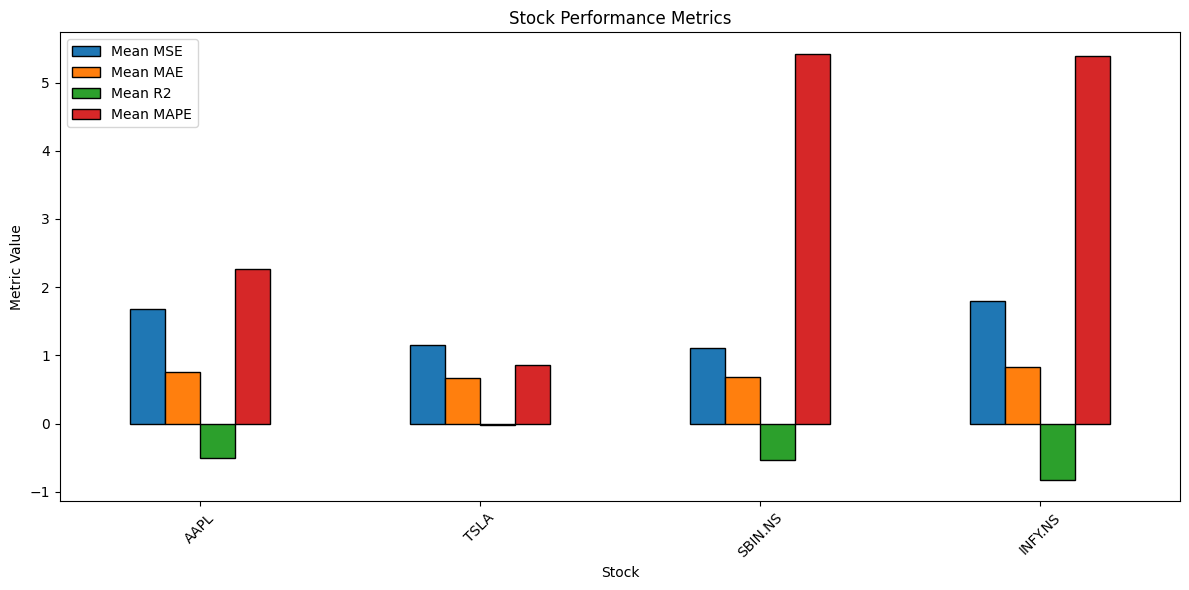

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# List of tickers to process
tickers = ['AAPL', 'TSLA', 'SBIN.NS', 'INFY.NS']  # Add more stocks as needed
start_date = '2000-01-01'
end_date = '2024-01-01'

# Function to create sequences for time series prediction
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])  # Predicting the closing price
    return np.array(X), np.array(y)

# Store overall results
all_results = []
stocks_metrics = []

# Process each stock
for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    # Load stock data
    df = yf.download(ticker, start=start_date, end=end_date)

    # Feature engineering
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()

    # Drop NA values
    df = df.dropna()

    # Selected features for prediction
    features = ['Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']

    # Normalize features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])

    # Create sequences for SVM
    sequence_length = 60
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeries Split for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    y_true_all, y_pred_all = [], []

    # Process each fold
    results = []
    for fold, (train_index, test_index) in enumerate(tscv.split(X, y)):
        print(f"Fold {fold + 1}...")

        # Train-test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # SVM Regressor model
        model = SVR(kernel='rbf', C=100, epsilon=0.1)  # SVM with RBF kernel
        model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten X_train for SVM

        # Predictions
        y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))  # Flatten X_test for SVM
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        results.append([ticker, fold + 1, mse, mae, r2, mape])

        # Plot True vs. Predicted for the fold
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='True Values', color='blue')
        plt.plot(y_pred, label='Predicted Values', color='red')
        plt.title(f"{ticker} - Fold {fold + 1}: True vs Predicted")
        plt.xlabel('Time Steps')
        plt.ylabel('Normalized Prices')
        plt.legend()
        plt.show()

        # Plot residuals for the fold
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title(f'{ticker} - Fold {fold + 1}: Residuals vs Predicted')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.show()

    # Overall metrics for the stock
    overall_mse = mean_squared_error(y_true_all, y_pred_all)
    overall_mae = mean_absolute_error(y_true_all, y_pred_all)
    overall_r2 = r2_score(y_true_all, y_pred_all)
    overall_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)

    print(f"\nOverall Metrics for {ticker}:")
    print(f"Mean Squared Error: {overall_mse}")
    print(f"Mean Absolute Error: {overall_mae}")
    print(f"R2 Score: {overall_r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {overall_mape}")

    # Residuals distribution
    residuals = np.array(y_true_all) - np.array(y_pred_all)
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', color='skyblue')
    plt.title(f'{ticker} - Residual Distribution')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Combine fold results into DataFrame
    results_df = pd.DataFrame(results, columns=['Ticker', 'Fold', 'MSE', 'MAE', 'R2 Score', 'MAPE'])
    all_results.append(results_df)

    # Store overall metrics
    stocks_metrics.append([ticker, overall_mse, overall_mae, overall_r2, overall_mape])

# Combine results for all stocks
all_results_df = pd.concat(all_results, ignore_index=True)
stocks_metrics_df = pd.DataFrame(stocks_metrics, columns=['Stock', 'Mean MSE', 'Mean MAE', 'Mean R2', 'Mean MAPE'])

# Print combined results
print("\nSummary of Performance for All Stocks:")
print(stocks_metrics_df)

# Plot performance metrics
stocks_metrics_df.plot(x='Stock', kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Stock Performance Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Processing AAPL...


[*********************100%***********************]  1 of 1 completed


Fold 1...


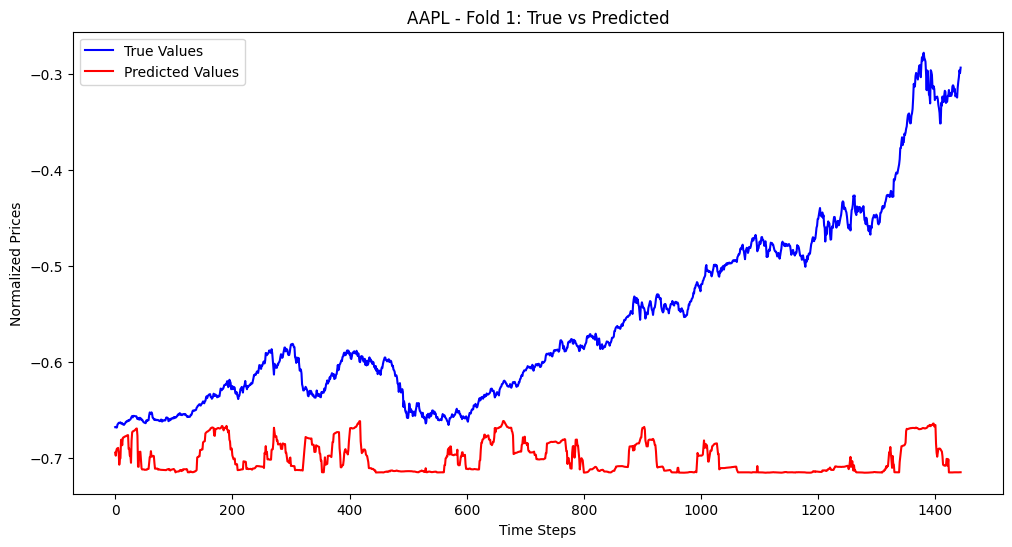

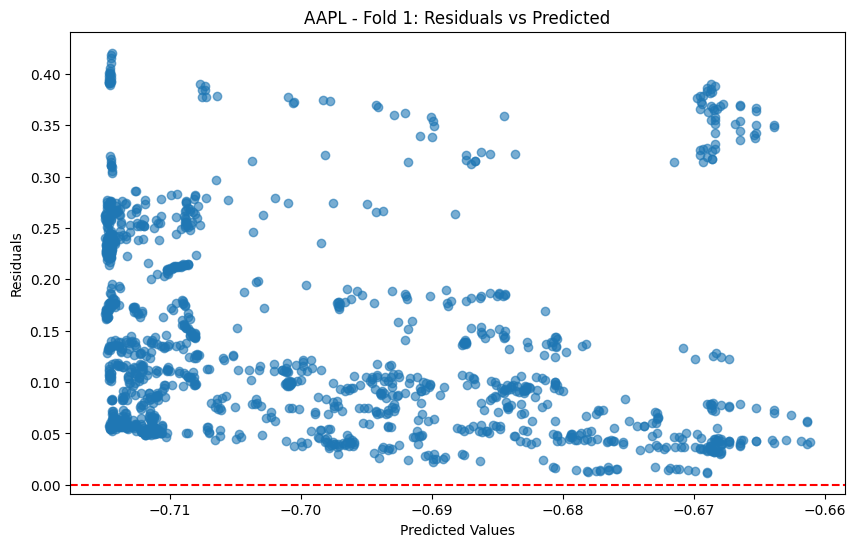

Fold 2...


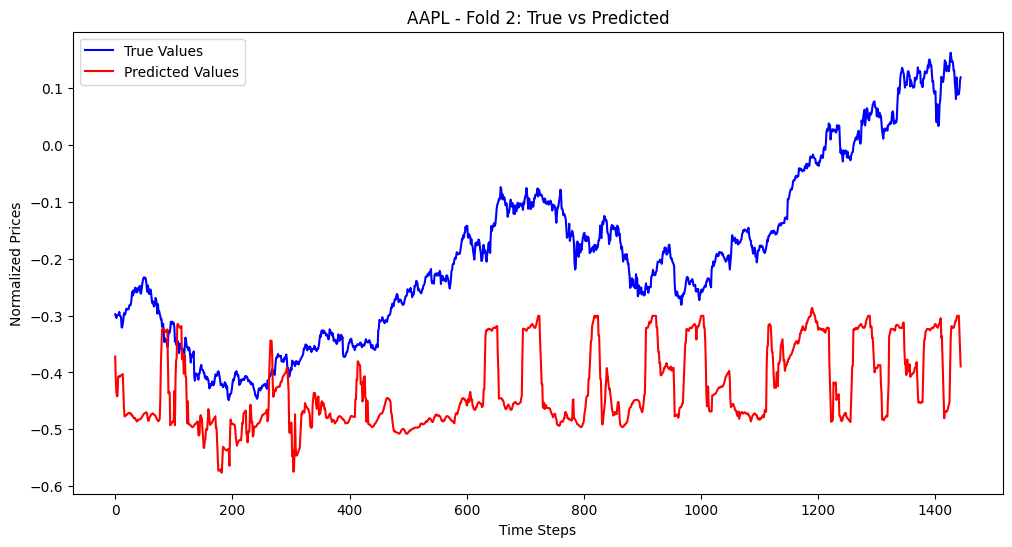

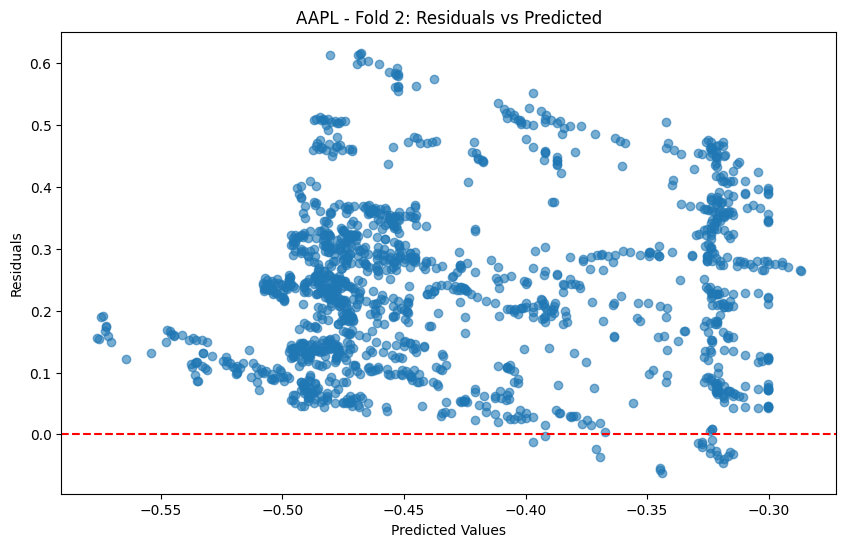

Fold 3...


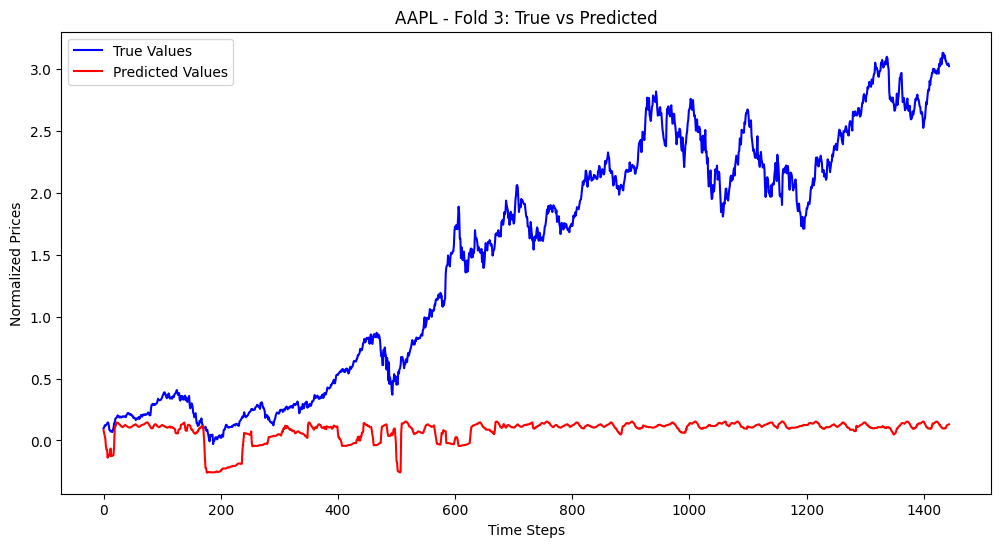

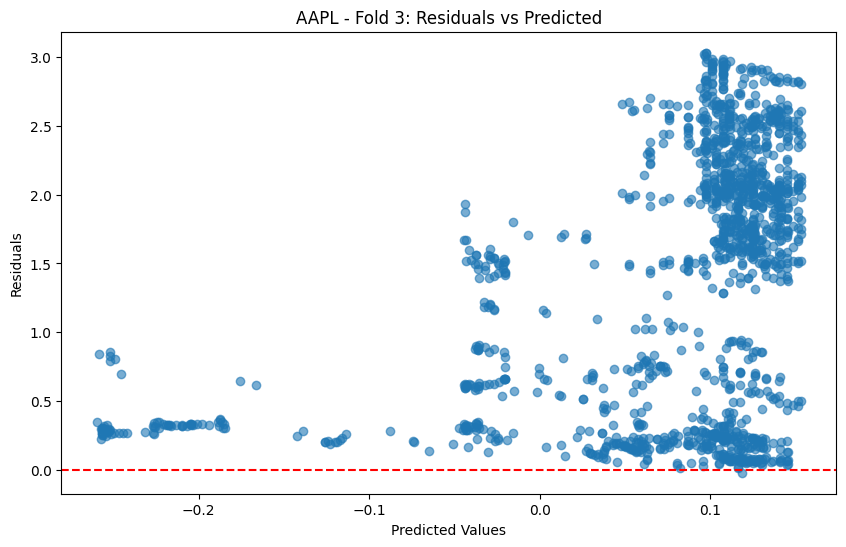


Overall Metrics for AAPL:
Mean Squared Error: 0.9826777208921219
Mean Absolute Error: 0.5949884456957109
R2 Score: 0.11979725888134507
Mean Absolute Percentage Error (MAPE): 1.9126864667591144


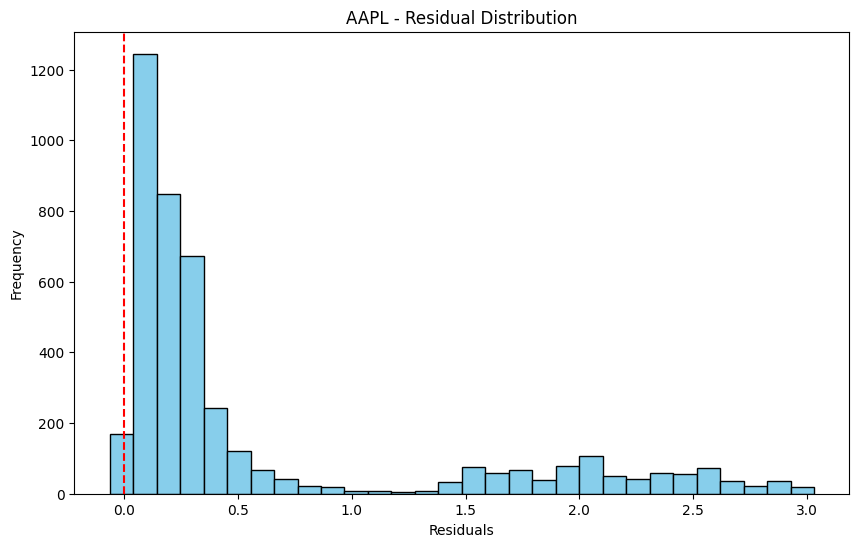


Processing TSLA...


[*********************100%***********************]  1 of 1 completed


Fold 1...


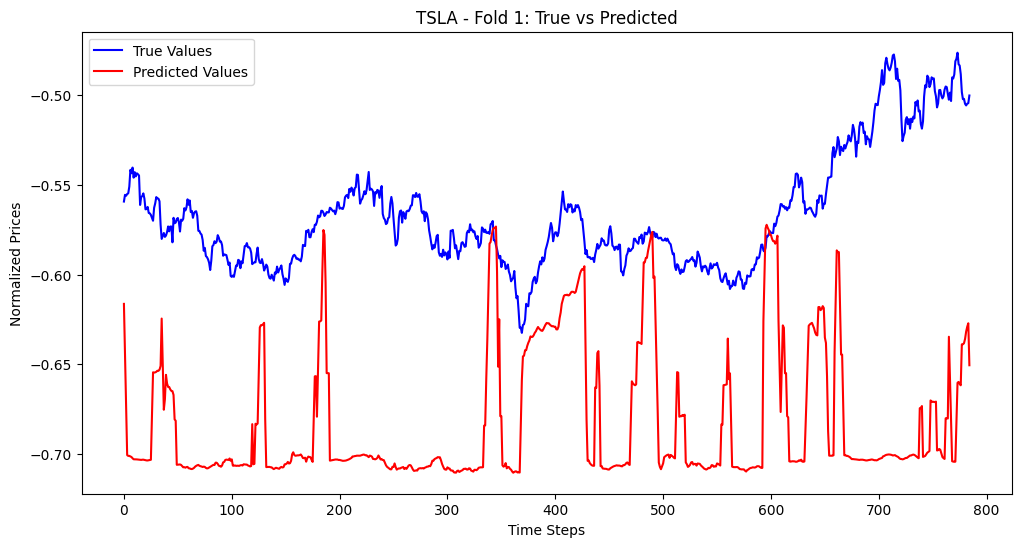

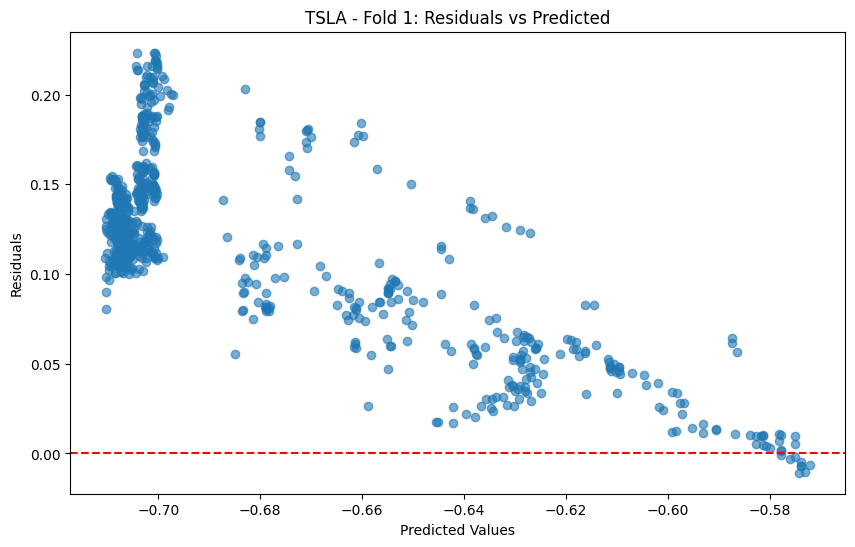

Fold 2...


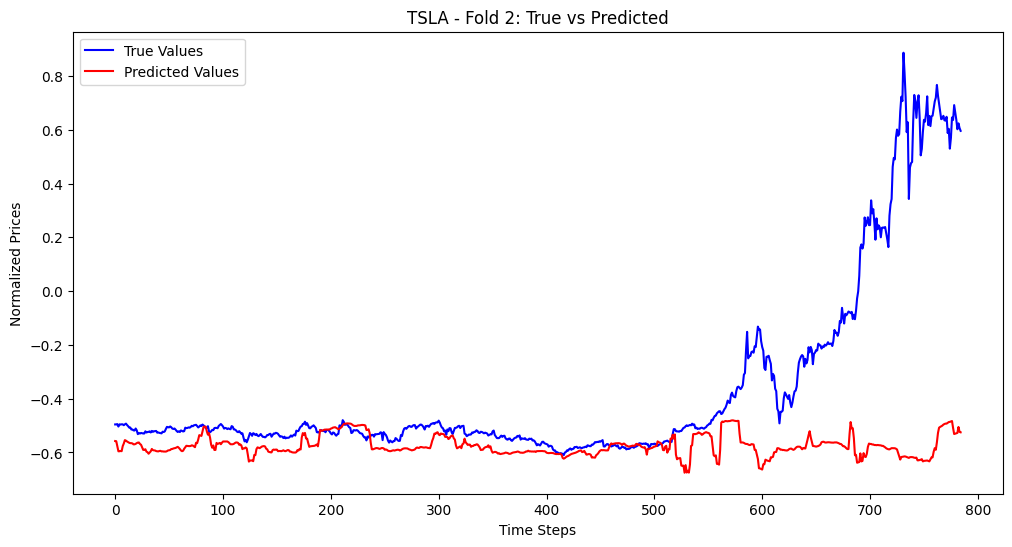

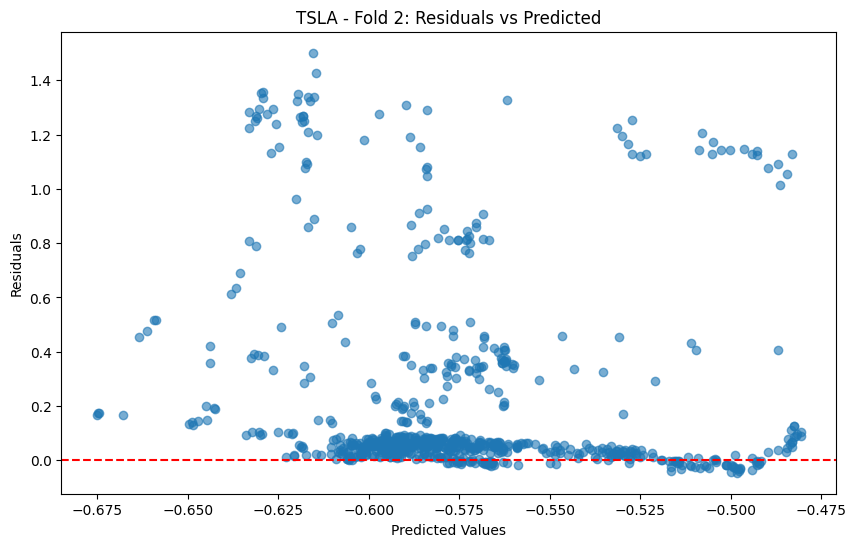

Fold 3...


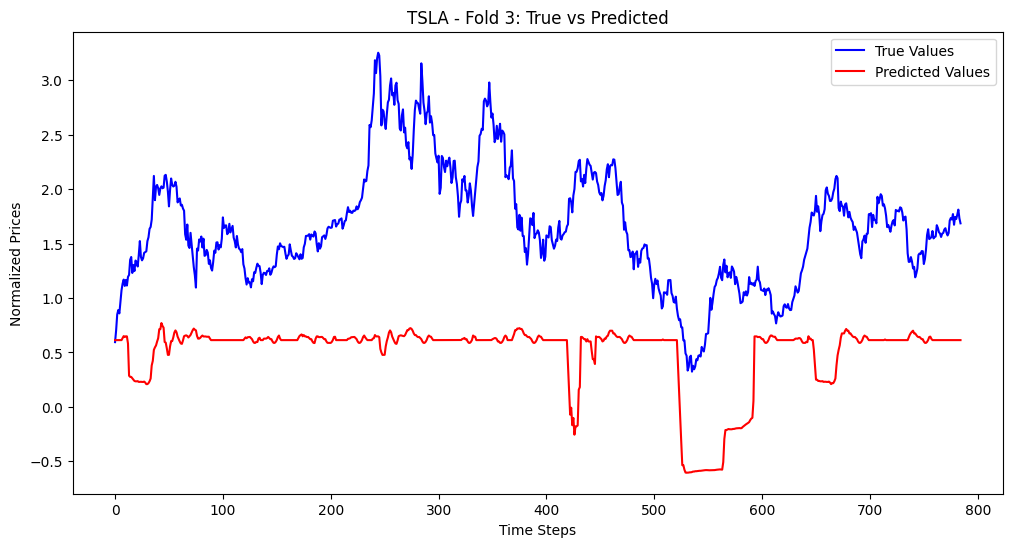

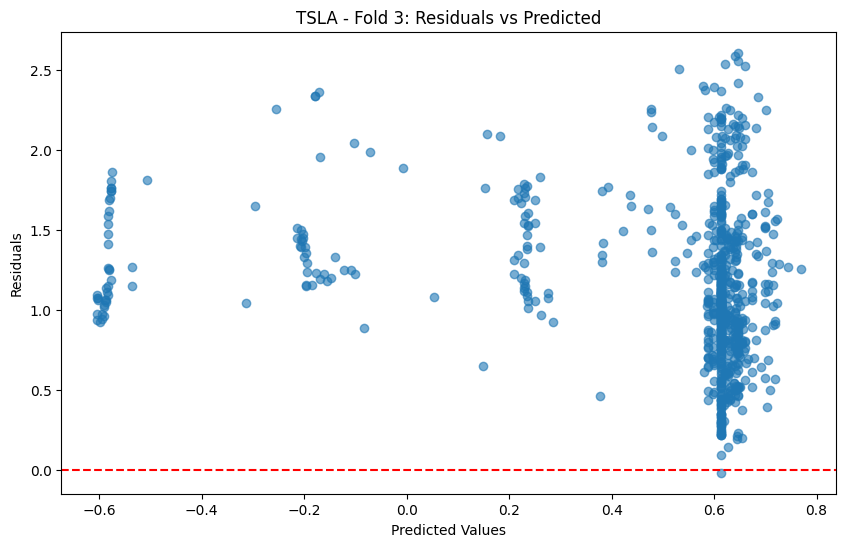


Overall Metrics for TSLA:
Mean Squared Error: 0.5849694882511473
Mean Absolute Error: 0.4935325745502309
R2 Score: 0.4867057819180358
Mean Absolute Percentage Error (MAPE): 0.7770489140995006


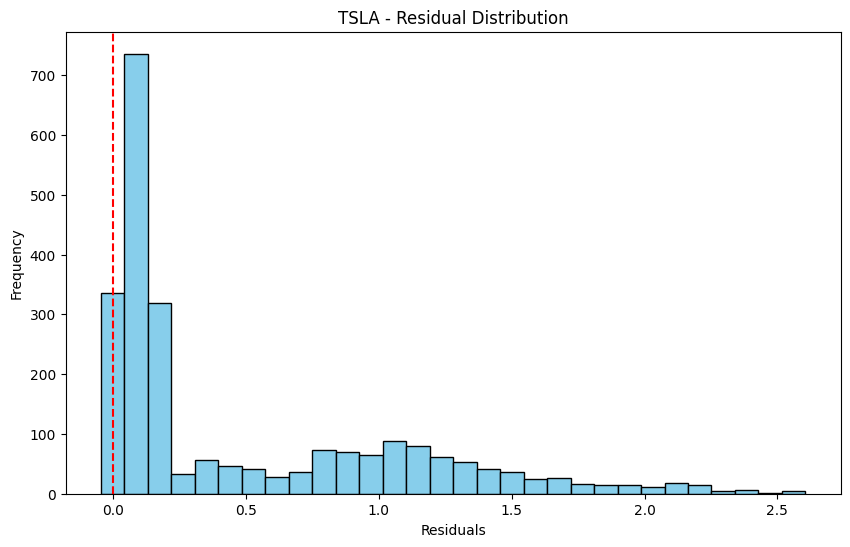

[*********************100%***********************]  1 of 1 completed


Processing SBIN.NS...
Fold 1...


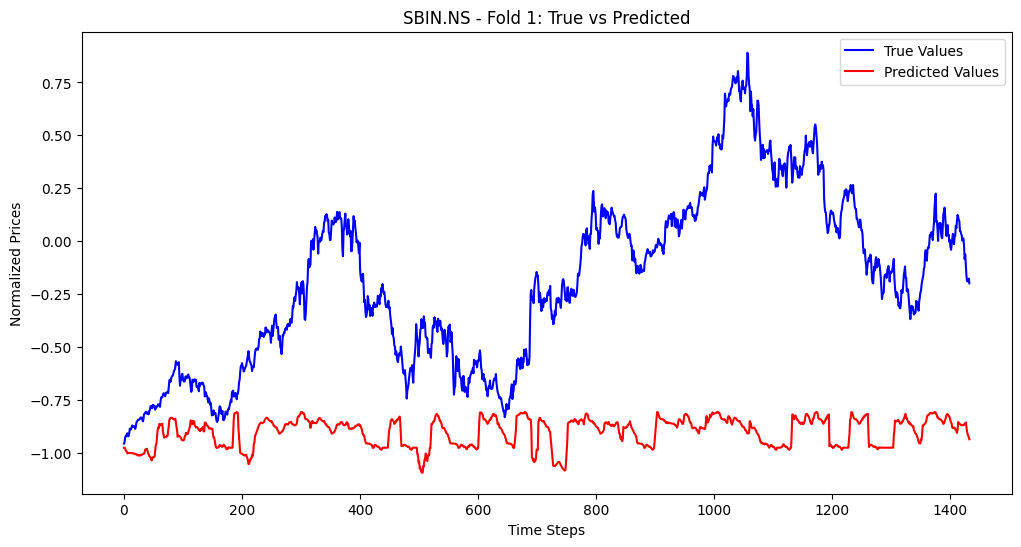

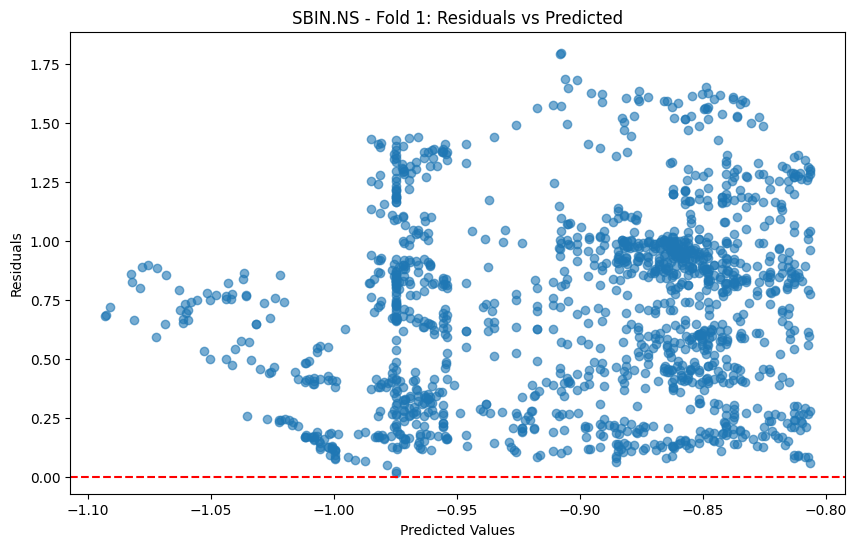

Fold 2...


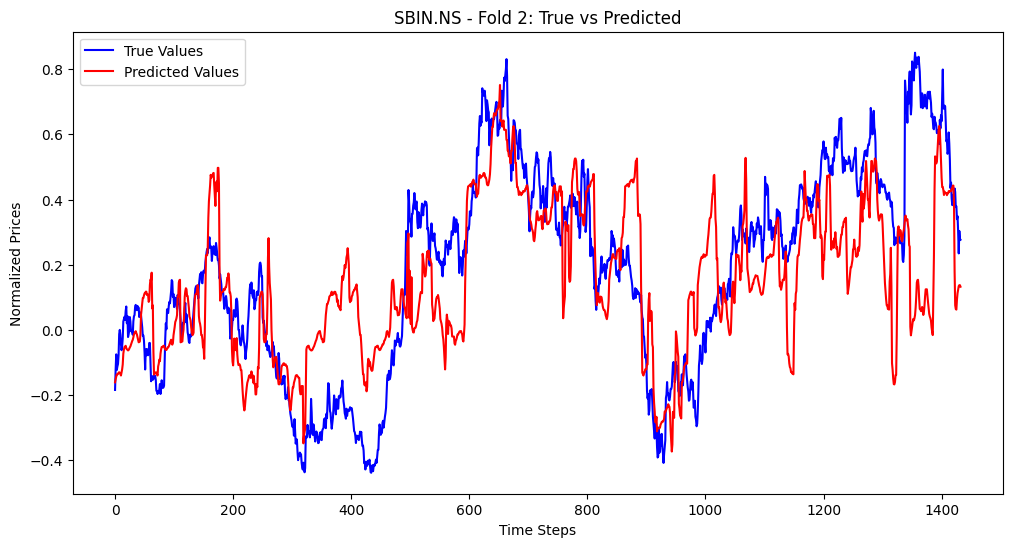

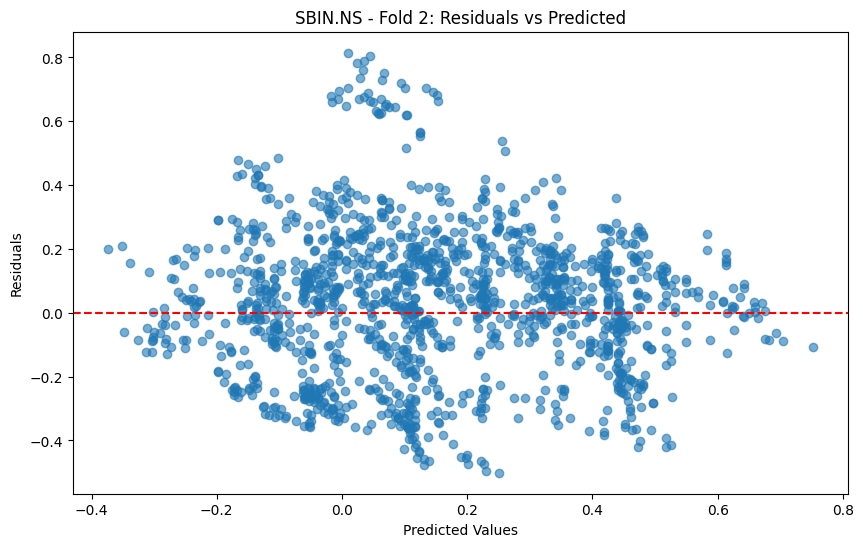

Fold 3...


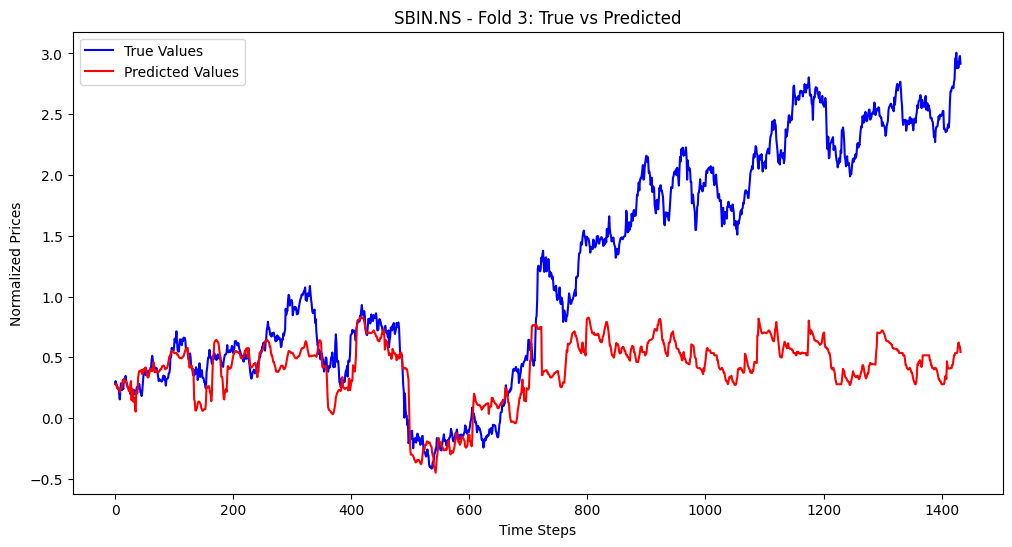

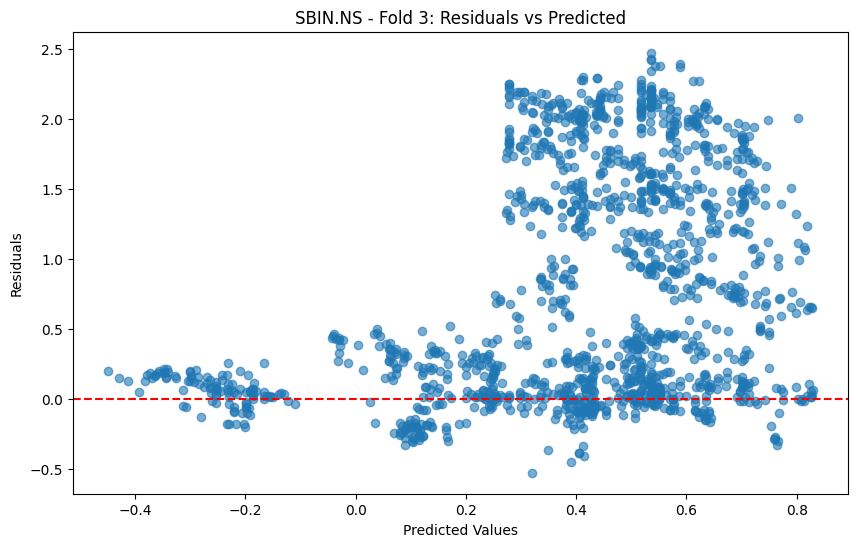


Overall Metrics for SBIN.NS:
Mean Squared Error: 0.6675691873952129
Mean Absolute Error: 0.5738066828665637
R2 Score: 0.07260053806295197
Mean Absolute Percentage Error (MAPE): 4.9856995290858555


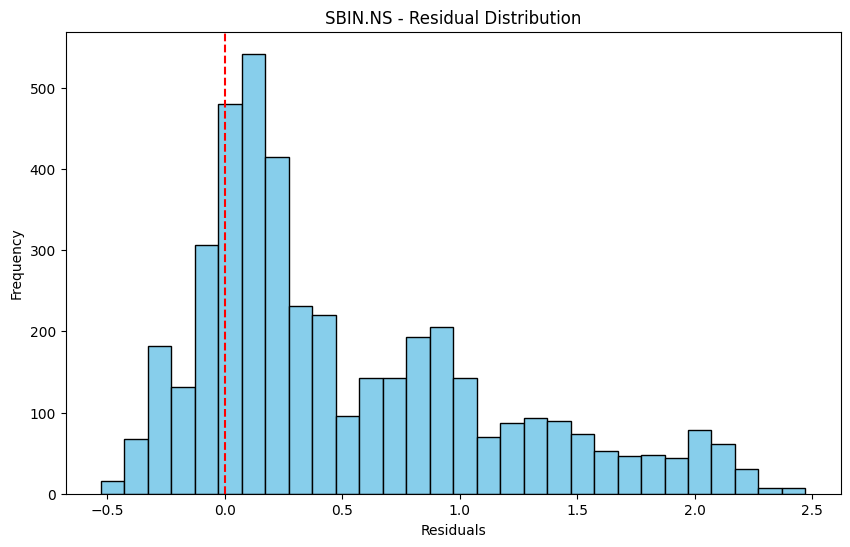

[*********************100%***********************]  1 of 1 completed


Processing INFY.NS...
Fold 1...


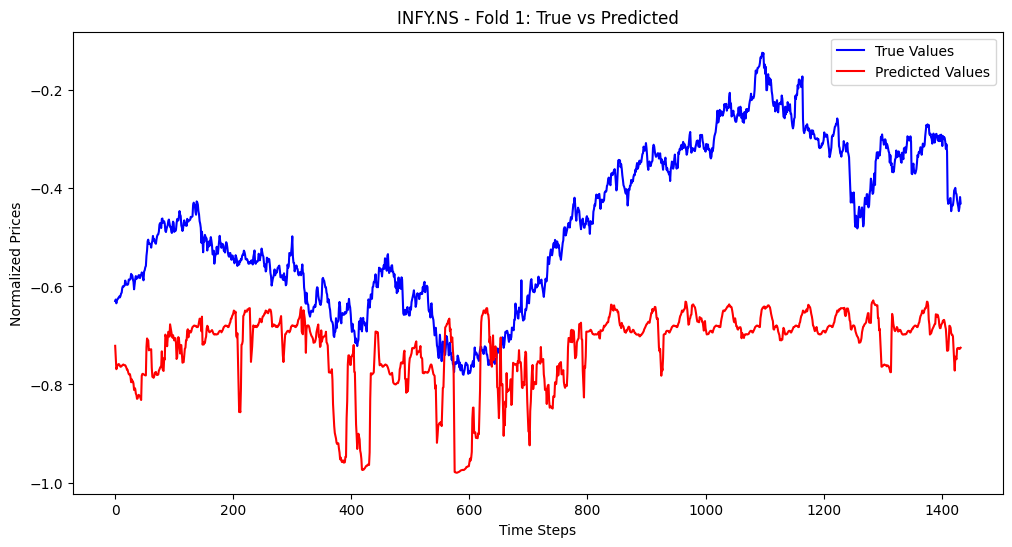

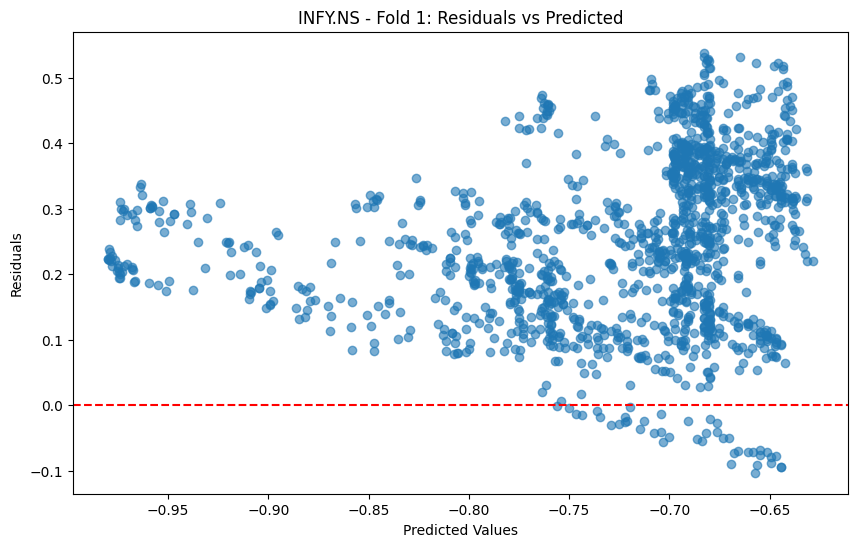

Fold 2...


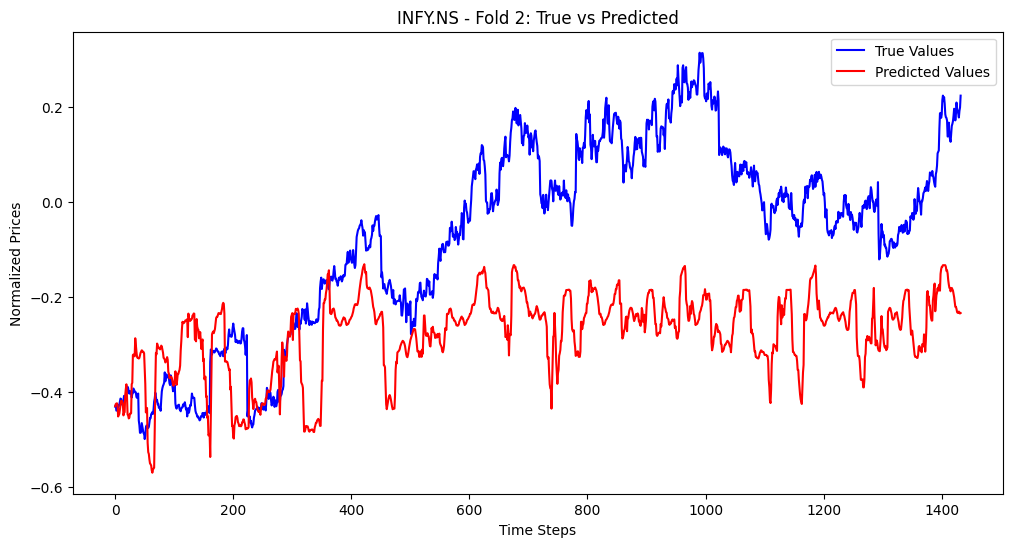

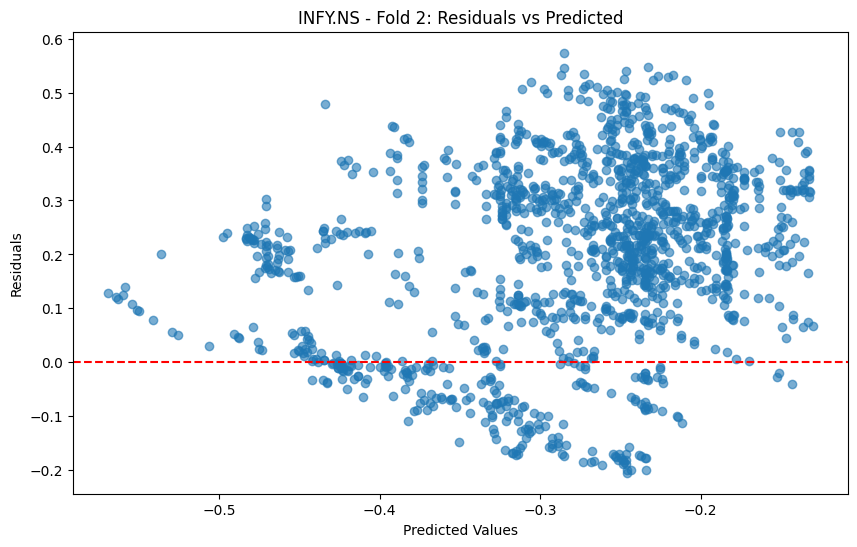

Fold 3...


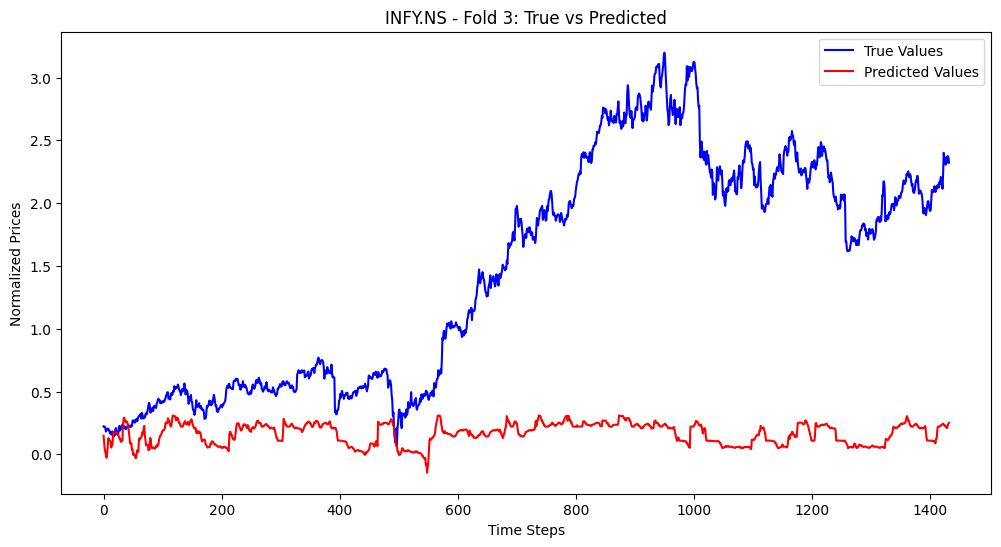

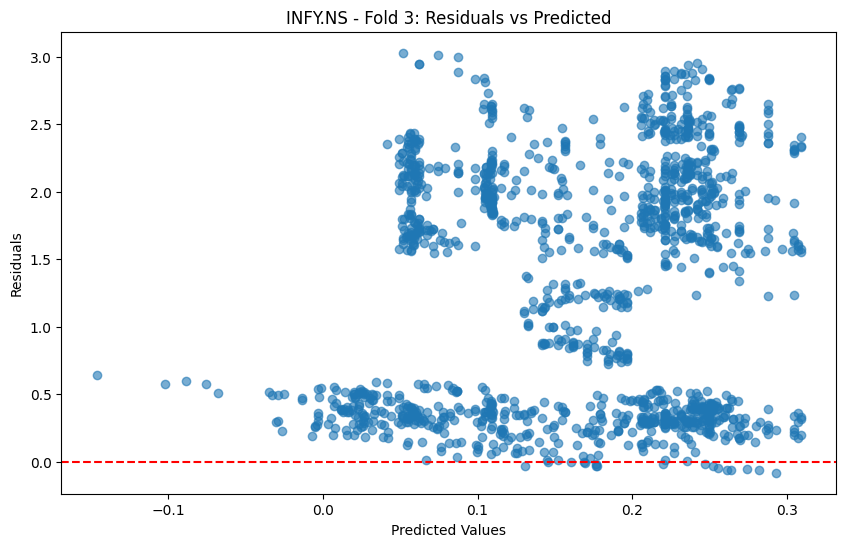


Overall Metrics for INFY.NS:
Mean Squared Error: 0.8679879631123809
Mean Absolute Error: 0.5920132458694086
R2 Score: 0.11999581701990758
Mean Absolute Percentage Error (MAPE): 4.268629442798765


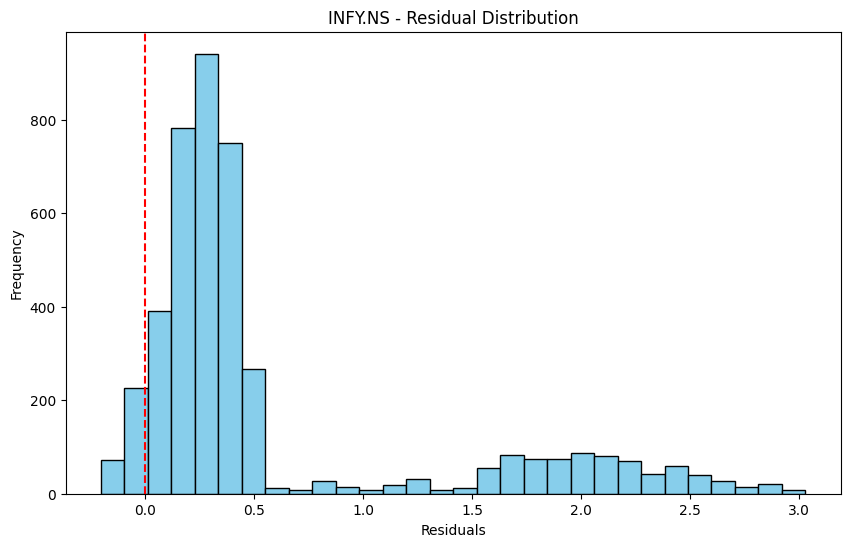


Summary of Performance for All Stocks:
     Stock  Mean MSE  Mean MAE   Mean R2  Mean MAPE
0     AAPL  0.982678  0.594988  0.119797   1.912686
1     TSLA  0.584969  0.493533  0.486706   0.777049
2  SBIN.NS  0.667569  0.573807  0.072601   4.985700
3  INFY.NS  0.867988  0.592013  0.119996   4.268629


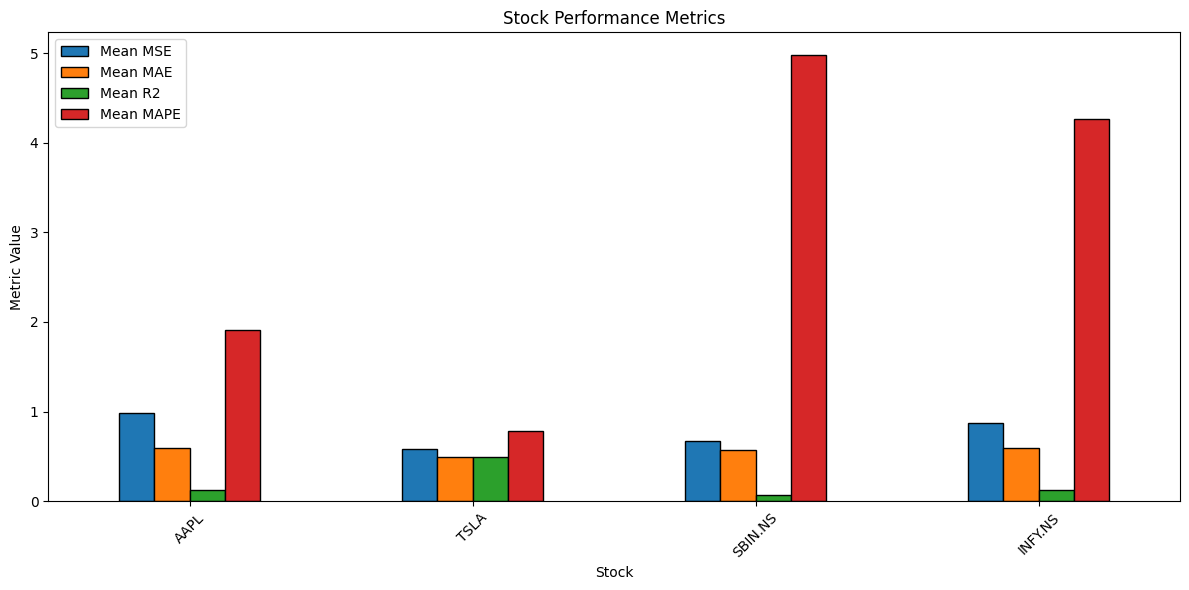

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor  # Import KNeighborsRegressor
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# List of tickers to process
tickers = ['AAPL', 'TSLA', 'SBIN.NS', 'INFY.NS']  # Add more stocks as needed
start_date = '2000-01-01'
end_date = '2024-01-01'

# Function to create sequences for time series prediction
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])  # Predicting the closing price
    return np.array(X), np.array(y)

# Store overall results
all_results = []
stocks_metrics = []

# Process each stock
for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    # Load stock data
    df = yf.download(ticker, start=start_date, end=end_date)

    # Feature engineering
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()

    # Drop NA values
    df = df.dropna()

    # Selected features for prediction
    features = ['Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']

    # Normalize features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])

    # Create sequences for KNN
    sequence_length = 60
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeries Split for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    y_true_all, y_pred_all = [], []

    # Process each fold
    results = []
    for fold, (train_index, test_index) in enumerate(tscv.split(X, y)):
        print(f"Fold {fold + 1}...")

        # Train-test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # KNeighbors Regressor model
        model = KNeighborsRegressor(n_neighbors=5)  # Using KNN with 5 neighbors
        model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten X_train for KNN

        # Predictions
        y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))  # Flatten X_test for KNN
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        results.append([ticker, fold + 1, mse, mae, r2, mape])

        # Plot True vs. Predicted for the fold
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='True Values', color='blue')
        plt.plot(y_pred, label='Predicted Values', color='red')
        plt.title(f"{ticker} - Fold {fold + 1}: True vs Predicted")
        plt.xlabel('Time Steps')
        plt.ylabel('Normalized Prices')
        plt.legend()
        plt.show()

        # Plot residuals for the fold
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title(f'{ticker} - Fold {fold + 1}: Residuals vs Predicted')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.show()

    # Overall metrics for the stock
    overall_mse = mean_squared_error(y_true_all, y_pred_all)
    overall_mae = mean_absolute_error(y_true_all, y_pred_all)
    overall_r2 = r2_score(y_true_all, y_pred_all)
    overall_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)

    print(f"\nOverall Metrics for {ticker}:")
    print(f"Mean Squared Error: {overall_mse}")
    print(f"Mean Absolute Error: {overall_mae}")
    print(f"R2 Score: {overall_r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {overall_mape}")

    # Residuals distribution
    residuals = np.array(y_true_all) - np.array(y_pred_all)
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', color='skyblue')
    plt.title(f'{ticker} - Residual Distribution')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Combine fold results into DataFrame
    results_df = pd.DataFrame(results, columns=['Ticker', 'Fold', 'MSE', 'MAE', 'R2 Score', 'MAPE'])
    all_results.append(results_df)

    # Store overall metrics
    stocks_metrics.append([ticker, overall_mse, overall_mae, overall_r2, overall_mape])

# Combine results for all stocks
all_results_df = pd.concat(all_results, ignore_index=True)
stocks_metrics_df = pd.DataFrame(stocks_metrics, columns=['Stock', 'Mean MSE', 'Mean MAE', 'Mean R2', 'Mean MAPE'])

# Print combined results
print("\nSummary of Performance for All Stocks:")
print(stocks_metrics_df)

# Plot performance metrics
stocks_metrics_df.plot(x='Stock', kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Stock Performance Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
